# Gradient Boosting for Cambridge UK Weather Time Series

Gradient boosting models for time series analysis of Cambridge UK temperature measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).

This notebook is being developed on [Google Colab](https://colab.research.google.com), primarily using [keras/tensorflow](https://www.tensorflow.org/guide/keras/sequential_model).  Initially I was most interested in short term temperature forecasts (less than 2 hours) but now mostly produce results up to 48 hours in the future for comparison with earlier [baselines](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb).

See my previous notebooks, web apps etc:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)

The linked notebooks, web apps etc contain further details including:
 * data description
 * data cleaning and preparation
 * data exploration

In particular, see the notebooks:
 * [cammet_baselines_2021](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) including persistent, simple exponential smoothing, Holt Winter's exponential smoothing and vector autoregression
 * [keras_mlp_fcn_resnet_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb), which uses a streamlined version of data preparation from [Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
 * [lstm_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb) with stacked LSTMs, bidirectional LSTMs and ConvLSTM1D networks
 * [cnn_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cnn_time_series.ipynb) with Conv1D, multi-head Conv1D, Conv2D and Inception-style models
 * [encoder_decoder](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/encoder_decoder.ipynb) which includes autoencoder with attention, encoder decoder with teacher forcing, transformer with teacher forcing and padding, encoder only with MultiHeadAttention
 * [tsfresh_feature_engineering](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb) automated feature engineering and selection for time series analysis of Cambridge UK weather measurements

Most of the above repositories, notebooks, web apps etc were built on both less data and less thoroughly cleaned data.

---

Install [darts](https://unit8co.github.io/darts/) because it is currently not available on google colab.

**WARNING**: You must restart the google colab runtime after this install.

In [1]:
#!pip install darts
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.

#!pip install "u8darts[torch]"
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.

!pip install "u8darts[pmdarima]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 5.1 MB/s 
     |████████████████████████████████| 85 kB 4.0 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 1.8 MB 58.3 MB/s 
     |████████████████████████████████| 9.9 MB 1.9 MB/s 
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
     |████████████████████████████████| 569 kB 66.9 MB/s 
     |████████████████████████████████| 11.2 MB 31.4 MB/s 
     |████████████████████████████████| 1.6 MB 30.3 MB/s 
     |████████████████████████████████| 965 kB 74.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled 

Load most of the other required packages.

In [1]:
import sys
import math
import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.preprocessing import StandardScaler

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)

%matplotlib inline

env: PYTHONHASHSEED=0




## Import ComLab Data

The measurements are relatively noisy and there are usually several hundred missing values every year; often across multiple variables.
Observations have been extensively cleaned but may still have issues.  Interpolation and missing value imputation have been used to fill all missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in September 2022 and occur every 30 mins.

**TODO** This code has grown to the point where moving some of it into functions makes sense.

Shape:


(247777, 51)


Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247777 entries, 2008-08-01 00:00:00 to 2022-09-19 00:00:00
Freq: 30T
Data columns (total 51 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ds                247633 non-null  datetime64[ns]
 1   y                 247633 non-null  float64       
 2   y_seasonal        247633 non-null  float64       
 3   y_des             247633 non-null  float64       
 4   humidity          247633 non-null  float64       
 5   pressure          247633 non-null  float64       
 6   dew.point         247633 non-null  float64       
 7   mixing_ratio      247633 non-null  float64       
 8   ah                247633 non-null  float64       
 9   wind.x            247633 non-null  float64       
 10  wind.y            247633 non-null  float64       
 11  day.sin.1         247633 non-null  float64       
 12  day.cos.1         247633 non-null  float64       
 13  year.sin

None


Summary stats:


,y,y_seasonal,y_des,humidity,pressure,dew.point,mixing_ratio,ah,wind.x,wind.y,...,isd_outlier,long_run,spike,cooksd_out,isd_3_sigma,isd_filled,hist_average,mi_filled,mi_spike_interp,lin_interp
count,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,2.476330e+05,2.476330e+05,...,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000
mean,10.167691,10.167691,0.000000,78.076761,1014.628248,5.917774,6.129673,7.518978,-1.692096e+00,-1.222764e+00,...,0.013908,0.020046,0.001312,0.000226,0.000614,0.020421,0.024629,0.018818,0.003340,0.003340
std,6.511192,5.558909,3.390303,17.543034,11.834168,5.149525,2.161222,2.494043,4.035673e+00,3.717951e+00,...,0.117108,0.140157,0.036204,0.015036,0.024768,0.141437,0.154993,0.135883,0.057693,0.057693
min,-7.000000,-0.278571,-15.055714,20.000000,963.000000,-10.000000,0.879888,1.136317,-2.880000e+01,-2.920000e+01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.200000,5.200000,-2.285714,67.000000,1008.000000,2.000000,4.431675,5.566512,-3.800000e+00,-3.181981e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,9.600000,-0.107143,82.000000,1016.000000,6.000000,5.855617,7.231109,-2.121320e-01,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.645000,14.364286,2.235714,92.000000,1023.000000,9.800000,7.557527,9.175923,1.530808e-16,2.461540e-15,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,37.800000,24.817857,23.632857,100.000000,1051.000000,20.900000,17.544837,19.939841,2.050610e+01,2.180000e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Raw data:


,ds,y,y_seasonal,y_des,humidity,pressure,dew.point,mixing_ratio,ah,wind.x,...,isd_outlier,long_run,spike,cooksd_out,isd_3_sigma,isd_filled,hist_average,mi_filled,mi_spike_interp,lin_interp
ds,,,,,,,,,,,,,,,,,,,,,
2008-08-01 00:00:00,2008-08-01 00:00:00,20.0,16.226667,3.773333,48.6300,1014.666667,8.055,7.047539,8.402381,-0.999378,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2008-08-01 00:30:00,2008-08-01 00:30:00,19.5,15.833333,3.666667,47.3425,1014.642857,7.360,6.647161,7.943441,-0.792970,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2008-08-01 01:00:00,2008-08-01 01:00:00,19.1,15.626667,3.473333,50.8250,1014.600000,7.775,6.964295,8.329259,-0.923953,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2008-08-01 01:30:00,2008-08-01 01:30:00,19.1,15.380000,3.720000,44.9500,1014.714286,6.590,6.150615,7.366457,-0.934391,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2008-08-01 02:00:00,2008-08-01 02:00:00,19.1,14.966667,4.133333,46.6000,1014.333333,7.020,6.381123,7.636861,-0.876812,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-18 22:00:00,2022-09-18 22:00:00,9.2,11.973333,-2.773333,82.0000,1024.000000,6.300,5.848736,7.320382,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-18 22:30:00,2022-09-18 22:30:00,9.2,11.693333,-2.493333,81.0000,1024.000000,6.100,5.776747,7.231109,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-18 23:00:00,2022-09-18 23:00:00,9.2,11.486667,-2.286667,81.0000,1024.000000,6.100,5.776747,7.231109,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


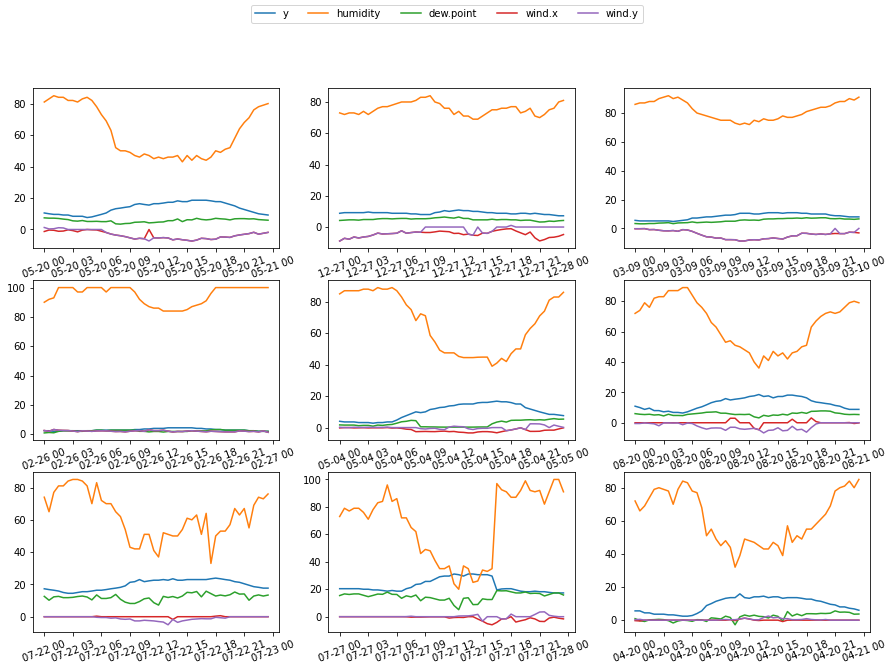

In [3]:
if 'google.colab' in str(get_ipython()):
    data_url = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetCleanishMissAnnotated2022.09.20.csv?raw=true"
else:
    data_url = "../data/CamMetCleanishMissAnnotated2022.09.20.csv"

df = pd.read_csv(data_url, parse_dates=['ds'])
df.set_index('ds', drop=False, inplace=True)
df = df[~df.index.duplicated(keep='first')]
df = df.asfreq(freq='30min')
df_orig = df


# Data reformating - https://www.cl.cam.ac.uk/research/dtg/weather/weather-raw-format.txt
for column in ['temperature', 'dew.point', 'wind.speed.mean']:
    df[column] /= 10

df['y'] = df['temperature']
    
# Deep copy avoids SettingWithCopyWarning
df = df.loc['2008-08-01 00:00:00':'2022-09-19 00:00:00', :].copy(deep=True)


# Convert wind direction and speed to x and y vectors, so the model can more easily interpret them.
wv = df['wind.speed.mean']
wd_rad = df['wind.bearing.mean'] * np.pi / 180  # Convert to radians

# Calculate the wind x and y components
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)


# From https://carnotcycle.wordpress.com/2012/08/04/how-to-convert-relative-humidity-to-absolute-humidity/
# Neither ah (absolute humidity) nor rh (relative humidity) proved useful for 
# forecasting but they may have utility for imputation
# See also: https://carnotcycle.wordpress.com/2017/08/01/compute-dewpoint-temperature-from-rh-t/
#           https://carnotcycle.wordpress.com/tag/formula/
#df['rh'] = 100 * (np.exp((18.678 * df['dew.point']) / (257.14 + df['dew.point'])) / np.exp((18.678 * df['y']) / (257.14 + df['y'])))
#df.loc[df['rh'] > 100.0, 'rh'] = 100.0
#df.loc[df['rh'] <  20.0, 'rh'] =  20.0
df['ah'] = 13.24715 * df['humidity'] * (np.exp((17.67 * df['y']) / (243.5 + df['y']))) / (273.15 + df['y'])
df['mixing_ratio'] = 6.112 * 6.2218 * df['humidity'] * np.exp(17.67 * df['y'] / (df['y'] + 243.5)) / \
                     (df['pressure'] - 0.06112 * df['humidity'] * np.exp(17.67 * df['y'] / (df['y'] + 243.5)))


# Convert to secs and add daily and yearly sinusoidal time terms
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = 365.2425 * day


def sinusoidal_arg(timestamp_s, denominator):
    return 2 * np.pi * timestamp_s / denominator


# df['day.sin']    = np.sin(sinusoidal_arg(timestamp_s, 1 * day))
# df['day.cos']    = np.cos(sinusoidal_arg(timestamp_s, 1 * day))
# df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

for i in [1, 2, 3]:
    df['day.sin.'  + str(i)] = np.sin(sinusoidal_arg(timestamp_s, i * day))
    df['day.cos.'  + str(i)] = np.cos(sinusoidal_arg(timestamp_s, i * day))
    df['year.sin.' + str(i)] = np.sin(sinusoidal_arg(timestamp_s, i * year))
    df['year.cos.' + str(i)] = np.cos(sinusoidal_arg(timestamp_s, i * year))


# Add daily spline-based time terms
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree  = degree,
        n_knots = n_knots,
        knots   = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation = "periodic",
        include_bias  = True,
    )


daily_obs = 48
hour_df = pd.DataFrame(
    np.linspace(0, day, daily_obs + 1).reshape(-1, 1),
    columns=["secs"],
)

yearly_obs = int(365.2425 * daily_obs)  # annual observations
month_df = pd.DataFrame(
    np.linspace(0, year, yearly_obs + 1).reshape(-1, 1),
    columns=["secs"],
)

# 12 splines approximating 12 month-like time components
day_splines = periodic_spline_transformer(day, n_splines=12).fit_transform(hour_df)
day_splines_df = pd.DataFrame(
    day_splines,
    columns=[f"day_spline_{i}" for i in range(day_splines.shape[1])],
)
day_secs_step = int(day / daily_obs)
day_splines_df['secs_since_midnight'] = range(0, day + day_secs_step, day_secs_step)

# pd.concat([hour_df, day_splines_df], axis="columns").plot(x="secs", cmap=plt.cm.tab20b)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

year_splines = periodic_spline_transformer(year, n_splines=12).fit_transform(month_df)
year_splines_df = pd.DataFrame(
    year_splines,
    columns=[f"year_spline_{i}" for i in range(year_splines.shape[1])],
)
year_splines_df['secs_elapsed'] = range(0, int(year), day_secs_step)



# Add seasonal mean temperature 'y_seasonal'
df['secs_since_midnight'] = ((df['ds'] - df['ds'].dt.normalize()) / pd.Timedelta('1 second')).astype(int)
df['doy'] = df['ds'].apply(lambda x: x.dayofyear - 1)
df['secs_elapsed'] = df['secs_since_midnight'] + df['doy'] * day

df_seasonal_y = df[['y', 'secs_elapsed']].groupby('secs_elapsed').mean('y')
df_seasonal_y.rename(columns={'y': 'y_seasonal'}, inplace=True)

df = pd.merge(df, df_seasonal_y,   on='secs_elapsed')
df = pd.merge(df, day_splines_df,  on='secs_since_midnight')
df = pd.merge(df, year_splines_df, on='secs_elapsed')

# Deseasonalise y
df['y_des'] = df['y'] - df['y_seasonal']
# df['dew.point_des'] = df['dew.point'] - df['dew.point_seasonal']


# Add Boruta-style "shadow" variables for feature selection
for var in ['y_des', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']:
    df[var + '_shadow'] = np.random.permutation(df[var])

# Add absolute values for variables which can be negative
for var in ['y_des', 'dew.point', 'wind.x', 'wind.y']:
    df[var + '_abs'] = abs(df[var])

# Add squared values for the main variables
for var in ['y_des', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']:
    df[var + '_square'] = df[var] ** 2


df.set_index('ds', drop=False, inplace=True)
df = df.asfreq(freq='30min')


# Reorder and drop temporary calculation columns
cols = ['ds', 'y', 'y_seasonal', 'y_des', 'humidity', 'pressure', \
        'dew.point', 'mixing_ratio', 'ah', 'wind.x', 'wind.y',  \
        'day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1', \
        'day.sin.2', 'day.cos.2', 'year.sin.2', 'year.cos.2', \
        'day.sin.3', 'day.cos.3', 'year.sin.3', 'year.cos.3', \
        'y_des_shadow', 'humidity_shadow', 'pressure_shadow', \
        'dew.point_shadow', 'wind.x_shadow', 'wind.y_shadow', \
        'y_des_abs', 'dew.point_abs', 'wind.x_abs', 'wind.y_abs', \
        'y_des_square', 'humidity_square', 'pressure_square', \
        'dew.point_square', 'wind.x_square', 'wind.y_square', \
        #'day_spline_0', 'day_spline_1', 'day_spline_2', 'day_spline_3', \
        #'day_spline_4', 'day_spline_5',  'day_spline_6', 'day_spline_7', \
        #'day_spline_8', 'day_spline_9', 'day_spline_10', 'day_spline_11', \
        #'year_spline_0', 'year_spline_1', 'year_spline_2', 'year_spline_3', \
        #'year_spline_4', 'year_spline_5',  'year_spline_6', 'year_spline_7', \
        #'year_spline_8', 'year_spline_9', 'year_spline_10', 'year_spline_11', \
        'missing', 'known_inaccuracy', 'isd_outlier', 'long_run', 'spike', \
        'cooksd_out', 'isd_3_sigma', 'isd_filled', 'hist_average', \
        'mi_filled', 'mi_spike_interp', 'lin_interp']
df = df[cols]


# For use in other notebooks
if not 'google.colab' in str(get_ipython()):
    data_loc = "../data/CamMetPrepped2022.09.20.csv"
    df.to_csv(data_loc)


print("Shape:")
display(df.shape)
print("\nInfo:")
display(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


def plot_examples(data, cols):
    """Plot 9 sets of observations in 3 * 3 matrix"""

    assert len(data) == 9

    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(9):
        for col in cols:
            axs[i].plot(data[i]['ds'], data[i][col])
            axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)
    
    fig.legend(cols, loc = 'upper center',  ncol = len(cols))
    
    return None


num_plots = 9
days = df.ds.dt.date.sample(n = num_plots).sort_values()
p_data = [df[df.ds.dt.date.eq(days[i])] for i in range(num_plots)]
cols   = ['y', 'humidity', 'dew.point', 'wind.x', 'wind.y']  # 'pressure',    

plot_examples(p_data, cols)

### Import tsfresh features

[tsfresh](https://tsfresh.readthedocs.io/en/latest/) features were generated and filtered in [this notebook]().  [Here](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html) is a list of the features extracted by tsfresh.

Features were generated for:
 * individual observations
   * no data leakage concerns so generated features are saved in a single file
 * rolling observations with window size of 50
   * 48 + 2 to capture all lagged features from the previous 24 hours
   * data leakage concerns mean features are generated and saved in 3 files
     * training data
     * validation data
     * testing data

The rolling window features are loaded after the data is split into train, valid and test sets.

First, load the individual observations features and merge with existing data:

In [ ]:
if 'google.colab' in str(get_ipython()):
    tsf_url = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/tsfresh.2022.09.20.csv.xz?raw=true"
else:
    tsf_url = "../data/tsfresh.2022.09.20.csv.xz"


tsf = pd.read_csv(tsf_url, compression='xz', parse_dates=['ds'])
tsf.set_index('ds', drop=False, inplace=True)
tsf = tsf.asfreq(freq='30min')

# drop former index column
tsf = tsf.drop('Unnamed: 0', axis = 1)

print("tsf:")
print(tsf.info())
print(tsf.columns, "\n")
print("df:")
print(df.info(), "\n")

cols_to_use = tsf.columns.difference(['ds'])
df = pd.merge(df, tsf[cols_to_use], left_index=True, right_index=True)

df.set_index('ds', drop=False, inplace=True)
df = df[~df.index.duplicated(keep='first')]
df = df.asfreq(freq='30min')
print("df:")
print(df.info())

tsf:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247777 entries, 2008-08-01 00:00:00 to 2022-09-19 00:00:00
Freq: 30T
Columns: 164 entries, y_des__sum_values to ds
dtypes: datetime64[ns](1), float64(163)
memory usage: 311.9 MB
None
Index(['y_des__sum_values', 'y_des__range_count__max_1__min_-1',
       'y_des__quantile__q_0.9', 'y_des__quantile__q_0.3',
       'y_des__quantile__q_0.4', 'y_des__quantile__q_0.6',
       'y_des__quantile__q_0.7', 'y_des__quantile__q_0.8',
       'y_des__quantile__q_0.2', 'y_des__quantile__q_0.1',
       ...
       'wind.y__quantile__q_0.3', 'wind.y__quantile__q_0.2',
       'wind.y__quantile__q_0.1', 'wind.y__minimum', 'wind.y__maximum',
       'wind.y__mean', 'wind.y__median', 'wind.y__sum_values',
       'wind.y__count_above__t_0', 'ds'],
      dtype='object', length=164) 

df:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247777 entries, 2008-08-01 00:00:00 to 2022-09-19 00:00:00
Freq: 30T
Data columns (total 50 columns):
 #   Column   


---

### Split data¶

I use data from 2018 for validation, 2019 for testing and the remaining data for training. These are entirely arbitrary choices. This results in an approximate 84%, 8%, 8% split for the training, validation, and test sets respectively.

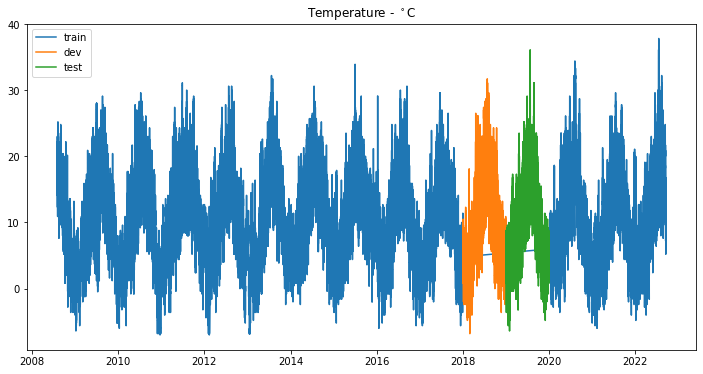

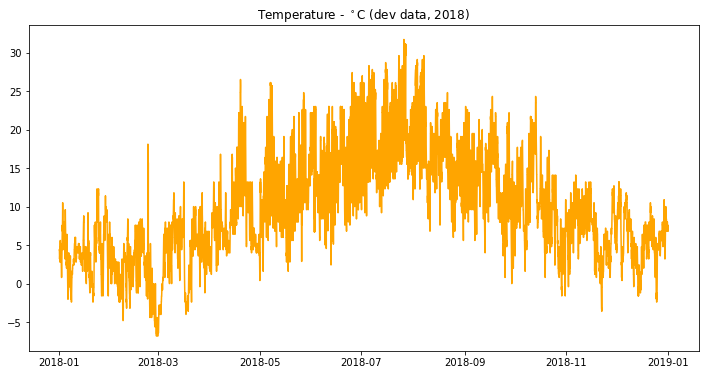

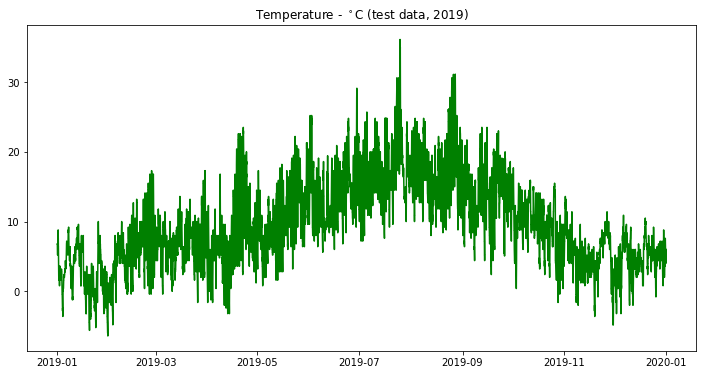

df.drop shape:  (247777, 51)
train shape:    (247777, 50)
valid shape:    (17520, 50)
test shape:     (17520, 50)


In [4]:
# keep_cols = ['ds', 'y', 'y_seasonal', 'y_des', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y', \
#              'day.sin', 'day.cos', 'year.sin', 'year.cos', 'missing', 'known_inaccuracy', \
#              'isd_outlier', 'long_run', 'spike', 'cooksd_out', 'isd_3_sigma', \
#              'isd_filled', 'hist_average', 'mi_filled', 'mi_spike_interp', 'lin_interp']

df['year'] = df['ds'].dt.year
train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
#train_df = df.loc[(df['year'] == 2015) | (df['year'] == 2016) | (df['year'] == 2017)]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]


plt.figure(figsize = (12, 6))
plt.plot(train_df.ds, train_df.y)
plt.plot(valid_df.ds, valid_df.y)
plt.plot(test_df.ds,  test_df.y)
plt.title('Temperature - $^\circ$C')
plt.legend(['train', 'dev', 'test'])
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(valid_df.ds, valid_df.y, color='orange')
plt.title('Temperature - $^\circ$C (dev data, 2018)')
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(test_df.ds, test_df.y, color='green')
plt.title('Temperature - $^\circ$C (test data, 2019)')
plt.show()


del_cols = ['ds', 'year']
train_df = train_df.drop(del_cols, axis = 1)
valid_df = valid_df.drop(del_cols, axis = 1)
test_df  = test_df.drop(del_cols,  axis = 1)
df = df.drop(['year'], axis = 1)

train_df = train_df.asfreq(freq='30min', method='ffill')
valid_df = valid_df.asfreq(freq='30min', method='ffill')
test_df  =  test_df.asfreq(freq='30min', method='ffill')


print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)



Now, load the rolling window tsfresh features and merge with existing data: 


In [5]:
def read_and_merge_tsfresh_features(df, ds, window=48):
    fn = 'tsfresh_' + str(window) + 'ish_' + ds + '.2022.09.20.csv.xz'

    if 'google.colab' in str(get_ipython()):
        tsf_url = 'https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/' + fn + '?raw=true'
    else:
        tsf_url = '../data/' + fn

    tsf = pd.read_csv(tsf_url, compression='xz', parse_dates=['ds'])


    # print("\n", ds)
    # print("tsf:", tsf.shape)
    tsf.set_index('ds', drop=False, inplace=True)
    tsf = tsf[~tsf.index.duplicated(keep='first')]
    tsf = tsf.asfreq(freq='30min')

    print("\n", ds)
    print("tsf:", tsf.shape)
    print("df: ", df.shape)

    df = pd.merge(df, tsf, left_index=True, right_index=True)

    df.set_index('ds', drop=True, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    df = df.asfreq(freq='30min')
    print("merged df:", df.shape)

    return df


train_df = read_and_merge_tsfresh_features(train_df, 'train')
valid_df = read_and_merge_tsfresh_features(valid_df, 'valid')
test_df  = read_and_merge_tsfresh_features(test_df,  'test')


 train
tsf: (247726, 15)
df:  (247777, 50)
merged df: (247726, 64)

 valid
tsf: (17470, 15)
df:  (17520, 50)
merged df: (17470, 64)

 test
tsf: (17470, 15)
df:  (17520, 50)
merged df: (17470, 64)



---

### Normalise data

Features do not need to be scaled for gradient boosting methods. Nonetheless, it can often be a
useful sanity check.

The [violin plot](https://en.wikipedia.org/wiki/Violin_plot) shows the distribution of features.

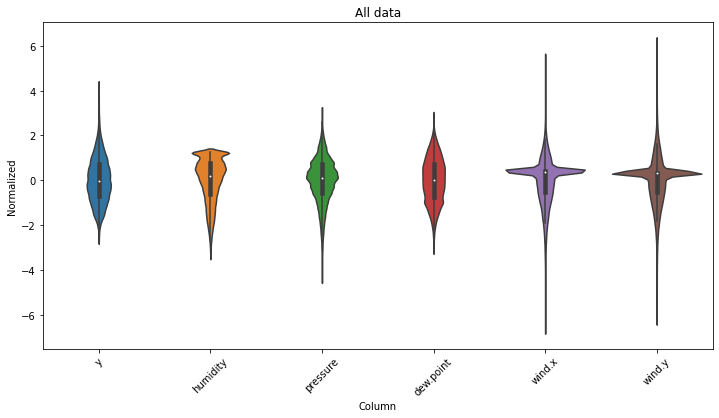

In [6]:
def inv_transform(scaler, data, colName, colNames):
    """An inverse scaler for use in model validation section

    For later use in plot_forecasts, plot_horizon_metrics and check_residuals
    
    See https://stackoverflow.com/a/62170887/100129"""

    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    
    return dummy[colName].values


cols = ['y', 'humidity', 'pressure', 'dew.point', 'wind.x', 'wind.y']
train_df_norm = train_df.loc[:, cols]
scaler = StandardScaler()
scaler.fit(train_df_norm)

train_df_norm = scaler.transform(train_df_norm)
# valid_df[valid_df.columns] = scaler.transform(valid_df[valid_df.columns] )
# test_df[test_df.columns]   = scaler.transform(test_df[test_df.columns] )

#df_std = scaler.transform(df)
df_std = pd.DataFrame(train_df_norm)
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(cols, rotation = 45)
ax.set_title('All data');

Some features have long tails but there are no glaring errors.


---

## Gradient Boosted Model Building

[Gradient boosted models](https://en.wikipedia.org/wiki/Gradient_boosting)  train an ensemble of weak prediction models, which are usually decision trees.  The ensemble model is iteratively built from weak learners and are added to produce a final strong learner.
Successive weak learners focus more on the examples that previous weak learners got wrong.  Historically, gradient boosted models have performed well in the [Kaggle](https://www.kaggle.com/) competitions.  The majority of [M5 forecasting accuracy competition entries used gradient boosted trees](https://www.sciencedirect.com/science/article/pii/S0169207021001874), specifically lightGBM.  See also, [Forecasting with trees](https://www.sciencedirect.com/science/article/pii/S0169207021001679) for more on the M5 competition and the dominance of boosted tree methods.  However, tree-based models may be unable to learn a trend and forecast outside the bounds of the training data.  This should not be a big problem with this cyclical data set.

Even simple lag-based feature engineering for [multi-variate time series multi-step forecasting](https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/) requires a considerable amount of effort, so a time series framework is beneficial.
I had hoped to use the [skforecast](https://joaquinamatrodrigo.github.io/skforecast/) framework.  Unfortunately, as of the current version (0.5.0) it does not support forecasts with multivariate data.  

The [sktime](https://www.sktime.org/en/stable/index.html) package supports boosting methods via their sklearn compatible [make_reduction](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.compose.make_reduction.html) function.  Initially it gave very poor results for the boosting methods I tried and the `make_reduction` function seemed to be somewhat of a second class option.  In it's defence, it has built in support for [tsfresh](https://www.sktime.org/en/latest/api_reference/auto_generated/sktime.transformations.panel.tsfresh.TSFreshFeatureExtractor.html) and [catch22](https://www.sktime.org/en/latest/api_reference/auto_generated/sktime.transformations.panel.catch22.Catch22.html) feature extraction plus [conformal interval](https://www.sktime.org/en/latest/api_reference/auto_generated/sktime.forecasting.conformal.ConformalIntervals.html) functionality among many other interesting features.

The [darts](https://unit8co.github.io/darts/) package is focused on time series forecasting but can also be used for filtering.

darts time series package:
  * pros
    * supports multi-variate data
    * allows custom lag selection
    * future covariates which many of the other time series packages do not support
  * cons
    * no integrated xgboost support but can use sklearn compatible [RegressionModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html)
    * random forest (from sklearn) implementation is slow
    * deep learning models currently don't install on google colab

The following are a few points I consider when building these gradient boosted models.

Forecast horizons:
  * next 24 hours - 48 steps ahead

Metrics:
 * mse - mean squared error
   * mse used for loss function to avoid potential problems with infinite values from the square root function
   * rmse - root mean squared error is used for comparison with baselines
   * Huber loss may be worth exploring in the future if outliers remain an issue
 * mae - median absolute error
 * mape - mean absolute percentage error 
   * Not used - mape fails when values, like temperature, become zero



Parameters to consider optimising:
 * lags
 * exogenous variables
   * time component representations
     * sinusoidal
     * [periodic spline features](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#periodic-spline-features)
  * [tsfresh](https://tsfresh.readthedocs.io/en/latest/) feature extraction
 * hyperparameters
```
param_grid = {
    'n_estimators':  [100, 500],
    'max_depth':     [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
```


Models considered:
   
 1. [darts lightgbm](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.gradient_boosted_model.html)
   * [lightgbm](https://lightgbm.readthedocs.io/)
   * from Microsoft
   * annecdotally, seems quite speedy

 2. [darts catboost](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.catboost_model.html)
   * [catboost](https://catboost.ai/)
   * from Yandex
   * annecdotally, seems more accurate on this data set

 3. [darts rf](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.random_forest.html)
   * unfortunately this was too slow
     * I stopped the process when eta exceeded 2 hours for a single small model


---

### 1. darts lightgbm


It is unrealistic to concurrently optimise all of the time series gradient boosting components on google colab.  So, an iterative process is necessary.


There are 3 major components to optimise:
 * feature selection
   * time component features
     * sinusoidal
     * spline-based
   * tsfresh features
 * lag selection
   * target series lags
   * past covariate (feature) lags
   * future covariate (time component) lags (which can include both past and future lags)
 * hyperparameter tuning


Start by loading the required darts imports:

In [7]:
from scipy import stats

from darts.models.forecasting.catboost_model import CatBoostModel
from darts.models.forecasting.gradient_boosted_model import LightGBMModel

from darts import TimeSeries
from darts.metrics import rmse, mae

Next, some utility function(s):

In [23]:
def check_obs_preds_lens_eq(obs, preds):
    obs_preds_lens_eq = 1

    if len(obs) != len(preds):
        print("obs:  ", len(obs))
        print("preds:", len(preds))
        obs_preds_lens_eq = 0

    return obs_preds_lens_eq


def rmse_(obs, preds):
    if check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.sqrt(np.mean((obs - preds) ** 2))


def mse_(obs, preds):
    if check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.mean((obs - preds) ** 2)


def mae_(obs, preds):
    "mean absolute error - equivalent to the keras loss function"
    if check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.mean(np.abs(obs - preds))      # keras loss
        # return np.median(np.abs(obs - preds))  # earlier baselines


def summarise_backtest(backtest, horizon = 48):

    if len(backtest[0]) == 1:
        print("\nBacktest RMSE:", round(rmse_(val_ser[-len(backtest):].values(), backtest.values()), 6))
        print("Backtest MAE: ",   round( mae_(val_ser[-len(backtest):].values(), backtest.values()), 6))
        
        print("\nbacktest['y_des']:")
        backtest_stats = stats.describe(backtest['y_des'].values())
        print("count\t", backtest_stats[0])
        print("mean\t",  round(backtest_stats[2][0], 6))
        print("std\t",   round(np.sqrt(backtest_stats[3][0]), 6))
        print("min\t",   round(np.min(backtest_stats[1]), 6))
        print("25%\t",   round(np.percentile(backtest['y_des'].values(), 25), 6))
        print("50%\t",   round(np.median(backtest['y_des'].values()), 6))
        print("75%\t",   round(np.percentile(backtest['y_des'].values(), 75), 6))
        print("max\t",   round(np.max(backtest_stats[1]), 6))
    elif len(backtest[0]) == horizon:
        preds_df = pd.concat([backtest[i].pd_dataframe() for i in range(len(backtest))], axis=0)
        trues_df = valid_df.loc[preds_df.index, ['y_des']]
        hist_comp = pd.concat([trues_df, preds_df['y_des']], axis = 1)
        hist_comp.columns = ['y_des', 'pred']
        list_int = [i for i in range(1, 49)]
        reps = len(hist_comp) // len(list_int)
        hist_comp['step'] = np.tile(list_int, reps)

        print("\nBacktest RMSE all:", round(rmse_(hist_comp['y_des'], hist_comp['pred']), 6))
        print("Backtest MAE all: ",    round(mae_(hist_comp['y_des'], hist_comp['pred']), 6))

        print("\nBacktest RMSE:", round(rmse_(hist_comp.loc[hist_comp['step'] == 48, 'y_des'], \
                                              hist_comp.loc[hist_comp['step'] == 48, 'pred']), 6))
        print("Backtest MAE: ",    round(mae_(hist_comp.loc[hist_comp['step'] == 48, 'y_des'], \
                                              hist_comp.loc[hist_comp['step'] == 48, 'pred']), 6))

        lasttest_stats = stats.describe(preds_df['y_des'])
        print("\nbacktest['y_des']:")
        print("count\t", len(preds_df['y_des']))
        print("mean\t",  round(lasttest_stats[2], 6))
        print("std\t",   round(np.sqrt(lasttest_stats[3]), 6))
        print("min\t",   round(np.min(lasttest_stats[1]), 6))
        print("25%\t",   round(np.percentile(preds_df['y_des'], 25), 6))
        print("50%\t",   round(np.median(preds_df['y_des']), 6))
        print("75%\t",   round(np.percentile(preds_df['y_des'], 75), 6))
        print("max\t",   round(np.max(lasttest_stats[1]), 6))


def plot_importances(model, \
                     data,  \
                     include_cols = None, \
                     y_col        = 'y_des',  \
                     exclude_cols = ['y', 'y_seasonal', 'y_des', 'dew.point_des', 'dew.point_seasonal']):
    '''Plot feature importances from lightGBM models

    WARNING: Only works with lags = 1 and lags_past_cov = 1
    '''

    col_indices = np.argsort(model.model.feature_importances_)

    if include_cols != None:
        col_names = pd.Series(include_cols)
    else:
        col_names = pd.Series(data.columns.difference(exclude_cols))

    col_names = pd.concat([pd.Series([y_col]), col_names])
    col_names = col_names.reset_index(drop=True)
    # print("col_names:\n", col_names[col_indices])

    importances = sorted(model.model.feature_importances_)
    importances = [i for i in importances if i >= 1]
    # print("importances:", importances, sep="\n")
    # print("col_indices:", col_indices, sep="\n")
    # print("col_names:", col_names, sep="\n")

    cols = col_names[col_indices]
    cols = cols[-len(importances):]
    # print("cols:", cols, sep='\n')

    plt.figure(figsize=(20, 10))
    plt.barh(width = importances, 
             y = cols,
             height  = 0.25);
    # plt.figure(figsize=(20, 10));


def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns = dictionary.keys())


def keep_key(d, k):
  """ models = keep_key(models, 'datasets') """
  return {k: d[k]}


def plot_horizon_metrics(hist, title, horizon=48):
    steps = [i for i in range(1, horizon+1)]

    # calculate metrics
    rmse_h, mae_h = np.zeros(horizon), np.zeros(horizon)

    for i in range(1, horizon+1):
      obs   = hist.loc[hist['step'] == i, 'y_des']
      preds = hist.loc[hist['step'] == i, 'pred']
      rmse_h[i-1] = rmse_(obs, preds)
      mae_h[i-1]  =  mae_(obs, preds)
      # mae_h[i]  = np.median(np.abs(obs - preds))  # for comparison with baselines

    # plot metrics for horizons
    fig, axs = plt.subplots(1, 2, figsize = (14, 7))
    fig.suptitle(title)
    axs = axs.ravel()

    mean_val_lab = title + ' mean value'
    axs[0].plot(steps, rmse_h, color='blue', label=title)
    var_rmse = np.array([0.39, 0.52, 0.64, 0.75, 0.86, 0.96, 1.06, 1.15, 1.23, 1.31, 1.38,
                         1.45, 1.51, 1.57, 1.63, 1.68, 1.73, 1.77, 1.81, 1.85, 1.89, 1.92,
                         1.96, 1.99, 2.02, 2.05, 2.08, 2.1 , 2.13, 2.15, 2.18, 2.2 , 2.22,
                         2.24, 2.26, 2.28, 2.3 , 2.31, 2.33, 2.35, 2.36, 2.38, 2.39, 2.4 ,
                         2.42, 2.43, 2.44, 2.45])
    axs[0].plot(steps, var_rmse, color='black', label='VAR')
    axs[0].hlines(np.mean(rmse_h), xmin=1, xmax=horizon, color='blue', linestyles='dotted', label=mean_val_lab)
    axs[0].hlines(np.mean(var_rmse), xmin=1, xmax=horizon, color='black', linestyles='dotted', label='VAR mean value')
    axs[0].set_xlabel("horizon - half hour steps")
    axs[0].set_ylabel("rmse")

    axs[1].plot(steps, mae_h, color='blue', label=title)
    var_mae = np.array([0.39, 0.49, 0.57, 0.66, 0.74, 0.83, 0.91, 0.98, 1.05, 1.12, 1.18,
                        1.24, 1.29, 1.34, 1.39, 1.43, 1.47, 1.5 , 1.53, 1.56, 1.59, 1.62,
                        1.64, 1.66, 1.68, 1.7 , 1.72, 1.73, 1.75, 1.76, 1.77, 1.78, 1.8 ,
                        1.81, 1.82, 1.83, 1.83, 1.84, 1.85, 1.85, 1.86, 1.86, 1.87, 1.87,
                        1.88, 1.88, 1.89, 1.89])
    axs[1].plot(steps, var_mae, color='black', label='VAR')
    axs[1].hlines(np.mean(mae_h), xmin=1, xmax=horizon, color='blue', linestyles='dotted', label=mean_val_lab)
    axs[1].hlines(np.mean(var_mae), xmin=1, xmax=horizon, color='black', linestyles='dotted', label='VAR mean value')
    axs[1].set_xlabel("horizon - half hour steps")
    axs[1].set_ylabel("mae")

    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()


def plot_obs_vs_preds(hist, title):
    plt.figure(figsize = (12, 16))
    plt.subplot(3, 1, 1)
    plt.scatter(x = hist['y_des'], y = hist['pred'])
    x_miss = hist.loc[hist['missing'] == 1.0, 'y_des']
    y_miss = hist.loc[hist['missing'] == 1.0, 'pred']
    plt.scatter(x = x_miss, y = y_miss, color='red', alpha=0.5, label='imputed observations')
    y_lim = plt.ylim()
    x_lim = plt.xlim()
    plt.plot(x_lim, y_lim, color = 'grey')  # 'k-', 
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.legend(loc='lower right')
    plt.title(title)


def plot_obs_preds_dists(obs, preds, title):
    plt.subplot(3, 1, 2)
    pd.Series(obs).plot(kind = 'density', label='observations')
    pd.Series(preds).plot(kind = 'density', label='predictions')
    plt.title(title)
    plt.legend()
    plt.tight_layout()


def plot_residuals(hist, title):
    plt.subplot(3, 1, 3)
    plt.scatter(x = range(len(hist)), y = hist['res'])
    hist['id.2'] = range(len(hist))
    x_miss = hist.loc[hist['missing'] == 1.0, 'id.2']
    y_miss = hist.loc[hist['missing'] == 1.0, 'res']
    plt.scatter(x = x_miss, y = y_miss, color='red', alpha=0.5, label='imputed observations')
    plt.axhline(y = 0, color = 'grey')
    plt.xlabel('Index position')
    plt.ylabel('Residuals')
    plt.legend(loc='lower right')
    plt.title(title)


def filter_out_missing(pos_neg_rmse_all, miss, lags, subplots):
    '''Check if obs (lags and horizon) missing == 1.0'''

    pos_neg_rmse = pd.Series(subplots)
    subplot_count = j = 0

    while subplot_count < subplots:
      restart = False
      idx = pos_neg_rmse_all[j]

      if idx < lags:
        j += 1
        continue

      # Check for contiguous indices - don't want 877, 878, 879
      if subplot_count > 0:
        for i in range(subplot_count):
          if abs(idx - pos_neg_rmse[i]) < lags:
            restart = True
            break

      if restart == False:
        lagged_miss  = (miss.iloc[idx - lags, :] == 1.0).any()
        horizon_miss = (miss.iloc[idx, :] == 1.0).any()
        missing = lagged_miss or horizon_miss

        if not missing:
          pos_neg_rmse[subplot_count] = idx
          subplot_count += 1

      j += 1

    return pos_neg_rmse


# TODO Replace x axis steps with timestamps
def plot_forecast_examples(hist, title, subplots = 3, horizon = 48, lags = 48):
    """Plot example forecasts with observations and lagged temperatures.
       Ensure examples are non-contiguous.

       First row shows near zero rmse forecasts.
       Second row shows most positive rmse forecasts.
       Third row shows most negative rmse forecasts.

       missing == 0 - ie no imputation for missing data
    """

    assert subplots in [3, 4, 5]

    miss  = hist.pivot_table(index='id', columns='step', values='missing')
    preds = hist.pivot_table(index='id', columns='step', values='pred')
    obs   = hist.pivot_table(index='id', columns='step', values='y_des')
    res   = hist.pivot_table(index='id', columns='step', values='res')
    miss.dropna(inplace=True)
    preds.dropna(inplace=True)
    obs.dropna(inplace=True)
    res.dropna(inplace=True)
    res_sign = np.sign(-res.mean(axis = 1))

    err = hist.pivot_table(index='id', columns='step', values='res^2')
    err.dropna(inplace=True)
    err_row_means = err.mean(axis = 1)
    rmse_rows = res_sign * np.sqrt(err_row_means)

    # choose forecasts - check for missing == 0
    neg_rmse_all = np.argsort(rmse_rows)
    pos_rmse_all = np.argsort(-rmse_rows)
    nz_rmse_all  = np.argsort(np.abs(rmse_rows))  # nz near zero

    nz_rmse  = filter_out_missing(nz_rmse_all,  miss, lags, subplots)
    pos_rmse = filter_out_missing(pos_rmse_all, miss, lags, subplots)
    neg_rmse = filter_out_missing(neg_rmse_all, miss, lags, subplots)

    plot_idx = np.concatenate((nz_rmse, pos_rmse, neg_rmse))

    # plot forecasts
    fig, axs = plt.subplots(3, subplots, sharex = True, sharey = True, figsize = (15, 10))
    axs = axs.ravel()

    for i in range(3 * subplots):
      axs[i].plot(range(-lags + 1, 1),
                  obs.iloc[plot_idx[i] - lags, :],
                  'blue',
                  label='lagged observations')
      axs[i].plot(range(0, horizon), 
                  obs.iloc[plot_idx[i], :],
                  'green',
                  label='observations')
      axs[i].plot(range(1, horizon + 1), 
                  preds.iloc[plot_idx[i], :],
                  'orange',
                  label='forecast')
      sub_title = "{0:d} {1:.4f}".format(plot_idx[i], rmse_rows[plot_idx[i]])
      axs[i].title.set_text(sub_title)
    
    fig.suptitle(title + "\nperiod idx, signed rmse")
    fig.text(0.5, 0.04, 'forecast horizon - half hour steps', ha='center')
    fig.text(0.04, 0.5, 'Temperature - $^\circ$C', va='center', rotation='vertical')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show();


def calculate_historic_comparison(backtest, df, horizon = 48):

    preds_df = pd.concat([backtest[i].pd_dataframe() for i in range(len(backtest))], axis=0)
    trues_df = df.loc[preds_df.index, ['y_des', 'y_seasonal', 'missing']]

    hist_comp = pd.concat([trues_df, preds_df['y_des']], axis = 1)
    hist_comp.columns = ['y_des', 'y_seasonal', 'missing', 'pred']
    hist_comp['y_des'] += hist_comp['y_seasonal']
    hist_comp['pred']  += hist_comp['y_seasonal']
    hist_comp['res']   = hist_comp['y_des'] - hist_comp['pred']
    hist_comp['res^2'] = hist_comp['res'] * hist_comp['res']
    hist_comp['res_sign'] = np.sign(hist_comp['res'])
    hist_comp['missing']  = hist_comp['missing'].astype(int)

    list_int = [i for i in range(1, horizon+1)]
    reps = len(hist_comp) // len(list_int)
    hist_comp['step'] = np.tile(list_int, reps)
    hist_comp['id']   = np.repeat([i for i in range(reps)], horizon)

    return hist_comp


#print("valid_df['y_des']:", valid_df['y_des'].describe(), sep="\n")
#summarise_backtest(backtest)



#### Feature selection


Both lightgbm and catboost provide feature importance measures.  They are most easily interpreted when lag = 1 for past covariates.  So, I use the lightgbm feature importance for feature selection at lag = 1 for both the target series and past covariates. 

Plot feature importance etc ...

...


In [9]:
series = TimeSeries.from_dataframe(train_df, value_cols='y_des')

# y_des excluded for lags = 1, lags_past_covariates = 1 to simplify variable importance plotting etc
# y_des must be included in past_cov for all other models
ex_cols = ['y', 'y_seasonal', 'y_des', 'dew.point_des', 'dew.point_seasonal']
past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(ex_cols)])


val_ser = TimeSeries.from_dataframe(valid_df, value_cols='y_des')
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns.difference(ex_cols)])


print("valid_df['y_des']:", valid_df['y_des'].describe(), sep="\n")
print()

model = LightGBMModel(lags = 1,
                      lags_past_covariates = 1)

model.fit(series, 
          past_covariates=past_cov)
backtest = model.historical_forecasts(series=val_ser, 
                                      past_covariates=val_past_cov,
                                      start=0.01, 
                                      retrain=False,
                                      verbose=True, 
                                      forecast_horizon=48,
                                      last_points_only=False)

summarise_backtest(backtest)
#if len(backtest[0]) == 1:
#  print("\nBacktest RMSE:", rmse(val_ser, backtest))
#  print("Backtest MAE: ",    mae(val_ser, backtest))
#  print("\nbacktest:", stats.describe(backtest['y_des'].values()))

# LightGBMModel() without output_chunk_length  = 48
#	target_lags	past_cov_lags	rmse	    mae
#  0     	 1	            1	2.530209	1.979172

# tsfresh 48ish features
# Backtest RMSE: 2.8612616171799052
# Backtest MAE:  2.173999377064532
# Backtest RMSE: 4.571554803796512
# Backtest MAE:  3.586239466526561

# non-redundant tsfresh features
# Backtest RMSE: 2.524525621410143
# Backtest MAE:  1.3102225067527289

# with humidity, rh and ah
# Backtest RMSE: 2.5564021035187174
# Backtest MAE:  1.3277637886324472

# rh replaces humidity but with 20% and 100% thresholds
# Backtest RMSE: 2.5564021035187174
# Backtest MAE:  1.3277637886324472

valid_df['y_des']:
count    17470.000000
mean        -0.354537
std          3.539904
min        -12.371429
25%         -2.571429
50%         -0.330952
75%          1.828571
max         12.914286
Name: y_des, dtype: float64



100%|██████████| 17249/17249 [05:45<00:00, 49.87it/s]



Backtest RMSE: 4.90715
Backtest MAE:  3.878417
obs:   17248
preds: 17249


NameError: ignored

In [19]:
summarise_backtest(backtest)


Backtest RMSE all: 2.153496
Backtest MAE all:  1.042627

Backtest RMSE: 2.726287
Backtest MAE:  1.426309

backtest['y_des']:
count	 827952
mean	 -0.717518
std	 3.39357
min	 -10.636206
25%	 -2.804786
50%	 -0.831612
75%	 1.201732
max	 11.029073



Summarise results ...

---

Plot feature importance ...

importances:
[1, 1, 2, 4, 4, 13, 15, 15, 16, 18, 18, 19, 21, 21, 23, 23, 27, 27, 32, 32, 34, 34, 36, 36, 37, 41, 41, 42, 45, 46, 51, 53, 55, 56, 62, 63, 64, 66, 67, 68, 68, 75, 99, 102, 114, 118, 128, 138, 143, 195, 234, 257]
col_indices:
[18 19  2 14 26 24 11 31 22 32 21 36 51 20 27 12 40 60 58 61 34  5 39 57
 35  7  8 13 30 28 23 38 59 54  4 50 17 15 10 37 47 44  1 33 49  9 48 52
 45 46 56 29  3  6 25 16 41 42 43  0 55 53]
col_names:
0          y_des
1             ah
2     cooksd_out
3      day.cos.1
4      day.cos.2
         ...    
57    year.cos.2
58    year.cos.3
59    year.sin.1
60    year.sin.2
61    year.sin.3
Length: 62, dtype: object
cols:
21                                          isd_outlier
36                                        wind.x_square
51                   y_des_48_sum_of_reoccurring_values
20                                           isd_filled
27                                              missing
12                                        dew.point_abs
40   

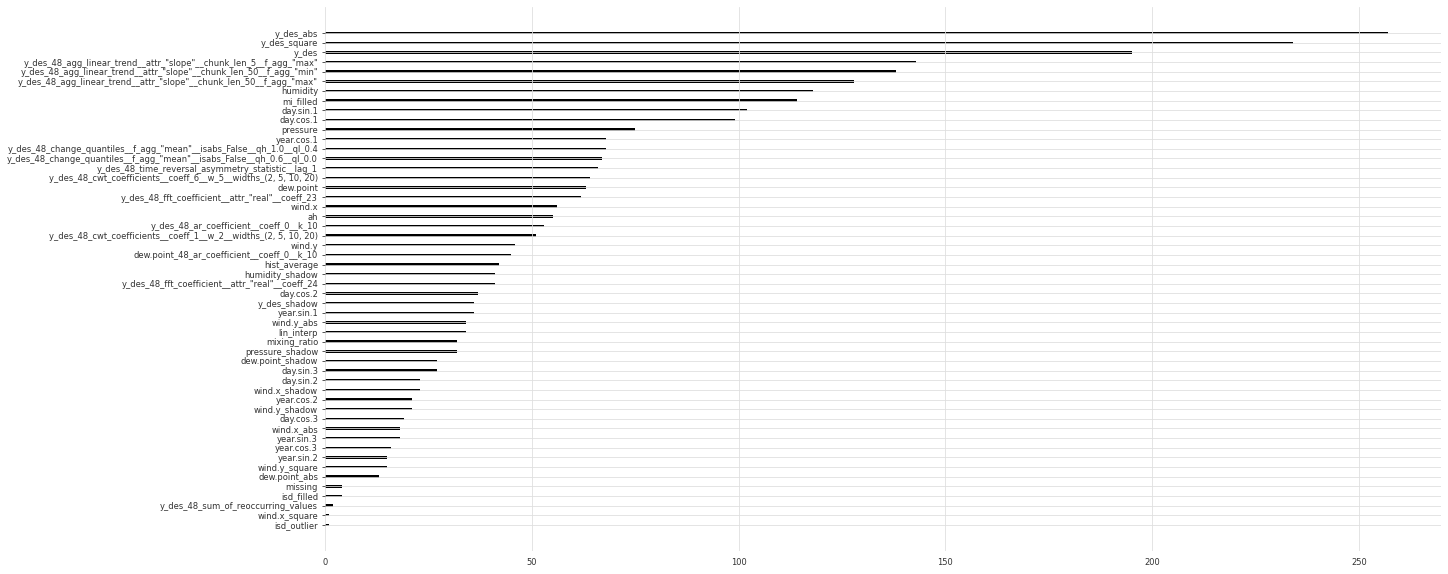

In [11]:
include_cols = ['humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y',   \
                'year.cos', 'year.sin', 'day.cos', 'day.sin', 'mi_filled', \
                'hist_average']

plot_importances(model, train_df)  #, include_cols=include_cols)

importances:
[4, 6, 9, 11, 12, 14, 28, 39, 40, 45, 46, 47, 54, 60, 66, 68, 74, 92, 94, 94, 95, 103, 110, 136, 143, 157, 162, 166, 207, 221, 292, 305]
col_indices:
[26  2 25 20 16 13 12  8 15 30 21 18 14 34  6 17 11 28 36 33 24 32  7 29
 22 39  9  5  1 27 31 19 23  4 38  3 37 10 35  0]
col_names:
0                y_des
1                   ah
2           cooksd_out
3              day.cos
4              day.sin
5            dew.point
6        dew.point_abs
7     dew.point_shadow
8     dew.point_square
9         hist_average
10            humidity
11     humidity_shadow
12     humidity_square
13         isd_3_sigma
14          isd_filled
15         isd_outlier
16    known_inaccuracy
17          lin_interp
18            long_run
19           mi_filled
20     mi_spike_interp
21             missing
22        mixing_ratio
23            pressure
24     pressure_shadow
25     pressure_square
26               spike
27              wind.x
28          wind.x_abs
29       wind.x_shadow
30       wind

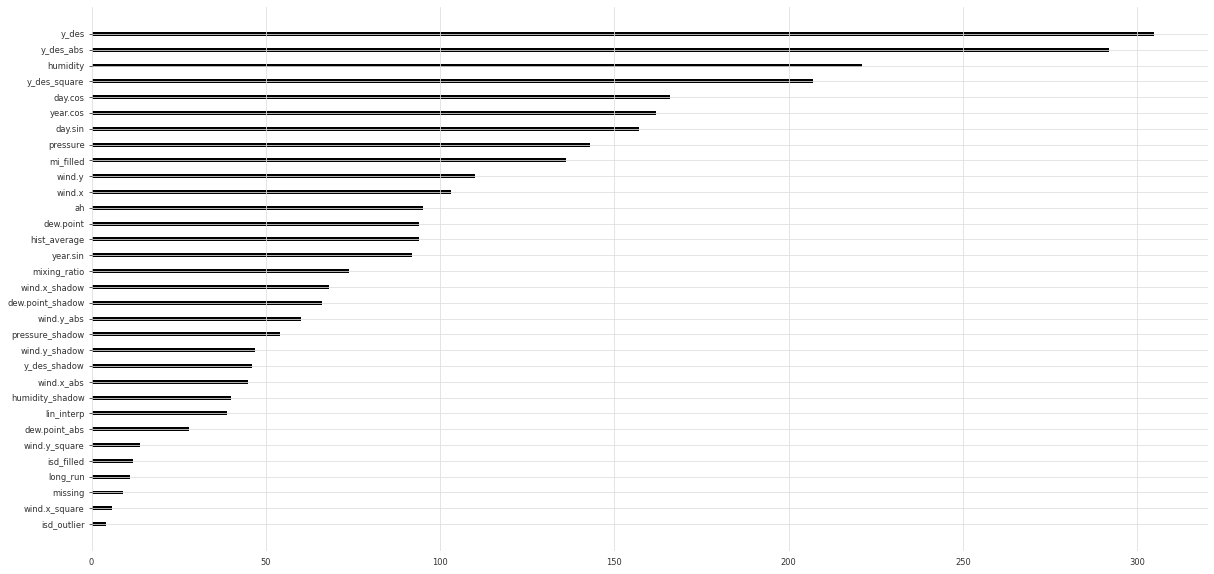

In [ ]:
include_cols = ['humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y',   \
                'year.cos', 'year.sin', 'day.cos', 'day.sin', 'mi_filled', \
                'hist_average']

plot_importances(model, train_df)  #, include_cols=include_cols)

In [ ]:
data = train_df
include_cols = None
y_col = 'y_des'
x_cols = ['y', 'y_seasonal', 'y_des', 'dew.point_des', 'dew.point_seasonal']
exclude_cols = x_cols

col_indices = np.argsort(model.model.feature_importances_)

if include_cols != None:
    col_names = pd.Series(include_cols)
else:
    col_names = pd.Series(data.columns.difference(exclude_cols))

col_names = pd.concat([pd.Series([y_col]), col_names])
col_names = col_names.reset_index(drop=True)

importances = sorted(model.model.feature_importances_)
importances = [i for i in importances if i >= 69]
print("importances:\n", importances, "\n", sep='')

inc_cols = col_names[col_indices]
inc_cols = inc_cols[-len(importances):]
print("inc_cols:\n", inc_cols, sep='')

print(inc_cols.to_list())

# display(df.loc[:, inc_cols.values].describe())
display(train_df.loc[:, inc_cols.values].describe())

importances:
[74, 92, 94, 94, 95, 103, 110, 136, 143, 157, 162, 166, 207, 221, 292, 305]

inc_cols:
22    mixing_ratio
39        year.sin
9     hist_average
5        dew.point
1               ah
27          wind.x
31          wind.y
19       mi_filled
23        pressure
4          day.sin
38        year.cos
3          day.cos
37    y_des_square
10        humidity
35       y_des_abs
0            y_des
dtype: object
['mixing_ratio', 'year.sin', 'hist_average', 'dew.point', 'ah', 'wind.x', 'wind.y', 'mi_filled', 'pressure', 'day.sin', 'year.cos', 'day.cos', 'y_des_square', 'humidity', 'y_des_abs', 'y_des']


,mixing_ratio,year.sin,hist_average,dew.point,ah,wind.x,wind.y,mi_filled,pressure,day.sin,year.cos,day.cos,y_des_square,humidity,y_des_abs,y_des
count,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,2.476330e+05,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000,247633.000000
mean,5.943234,-0.006551,0.022743,5.478962,7.292997,-2.706069,-2.291756e+00,0.017752,1011.496321,-0.018354,0.135589,0.140425,10.055263,78.816964,2.461757,-0.079081
std,2.106436,0.656282,0.149084,4.984238,2.439284,4.464531,4.293817e+00,0.132049,13.443653,0.656746,0.742207,0.740697,16.013802,16.168779,1.998758,3.170024
min,0.879888,-1.000000,0.000000,-10.000000,1.136317,-28.800000,-2.450000e+01,0.000000,963.000000,-1.000000,-1.000000,-1.000000,0.000000,20.000000,0.000000,-15.055714
25%,4.455018,-0.624652,0.000000,2.000000,5.499445,-6.434672,-5.515433e+00,0.000000,1001.000000,-0.608761,-0.615133,-0.608761,1.063845,71.000000,1.031429,-1.820000
50%,5.433304,0.005835,0.000000,4.900000,6.733274,-1.272792,-8.485281e-01,0.000000,1014.000000,-0.130526,0.240908,0.258819,3.415456,82.000000,1.848095,-0.714286
75%,7.313508,0.602255,0.000000,9.300000,8.922816,0.000000,9.674710e-16,0.000000,1021.000000,0.608761,0.919876,0.923880,12.501276,90.000000,3.535714,1.885714
max,15.475436,1.000000,1.000000,20.900000,17.930435,20.506097,2.180000e+01,1.000000,1051.000000,1.000000,1.000000,1.000000,558.511937,100.000000,23.632857,23.632857


In [ ]:
series = TimeSeries.from_dataframe(train_df, value_cols='y_des')
past_cov = TimeSeries.from_dataframe(train_df.loc[:, inc_cols])

val_ser = TimeSeries.from_dataframe(valid_df, value_cols='y_des')
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, inc_cols])


print("valid_df['y_des']:\n", valid_df['y_des'].describe(), "\n", sep='')


model1 = LightGBMModel(lags = 1,
                       lags_past_covariates = 1)

model1.fit(series, 
           past_covariates=past_cov)
backtest = model1.historical_forecasts(series=val_ser, 
                                       past_covariates=val_past_cov,
                                       start=0.01, 
                                       retrain=False,
                                       verbose=True, 
                                       forecast_horizon=48,  )
                                       #last_points_only=False)

summarise_backtest(backtest)
#if len(backtest[0]) == 1:
#  print("\nBacktest RMSE:", rmse(val_ser, backtest))
#  print("Backtest MAE:",     mae(val_ser, backtest))
#  print("\nbacktest:", stats.describe(backtest['y_des'].values()))


# LightGBMModel() without output_chunk_length  = 48
#	target_lags	past_cov_lags	rmse	    mae
#  0     	 1	            1	2.530209	1.979172

# tsfresh 48ish features - feature_importances_ >= 50
# Backtest RMSE: 2.878036846821661
# Backtest MAE: 2.1981357095575316
# Backtest RMSE: 4.6211965752619255
# Backtest MAE:  3.6207677720517264

# tsfresh 48ish features - feature_importances_ >= 100
# Backtest RMSE: 4.645481505574649
# Backtest MAE:  3.628352563757912

# feature_importances_ >= 0
# Backtest RMSE: 0.9712860180698543
# Backtest MAE:  0.5159408377313741
#
# Backtest RMSE: 2.524525621410143
# Backtest MAE: 1.3102225067527289

# feature_importances_ >= 5
# Backtest RMSE: 2.547860647069125
# Backtest MAE:  1.325798124030331

# feature_importances_ >= 10
# Backtest RMSE: 0.9622501501346592
# Backtest MAE: 0.514677701686563
# 
# Backtest RMSE: 2.556347980677272
# Backtest MAE:  1.3205401197840225

# feature_importances_ >= 20
# Backtest RMSE: 0.9865277241817688
# Backtest MAE:  0.5355360116255332

# feature_importances_ >= 15
# Backtest RMSE: 0.9566517297164219
# Backtest MAE:  0.5130991945354627
# Best so far
# Backtest RMSE: 2.543816301219165
# Backtest MAE:  1.3240200177416295

# feature_importances_ >= 18
# Backtest RMSE: 1.0365639037791354
# Backtest MAE:  0.5545886198716407

# feature_importances_ >= 17
# Backtest RMSE: 0.9891332910343054
# Backtest MAE:  0.5401072695649994

# feature_importances_ >= 16
# Backtest RMSE: 0.9566517297164219
# Backtest MAE:  0.5130991945354627
# Same as feature_importances_ >= 15 above, there is no 15

# feature_importances_ >= 14
# Backtest RMSE: 0.9631034055540753
# Backtest MAE:  0.5190709755297378

# feature_importances_ >= 12 - no 13 importances
# Backtest RMSE: 0.9622501501346592
# Backtest MAE:  0.514677701686563

# feature_importances_ >= 50
# Backtest RMSE: 2.5986235851724513
# Backtest MAE:  1.3489573768703422

valid_df['y_des']:
count    17520.000000
mean        -0.357674
std          3.535530
min        -12.371429
25%         -2.567857
50%         -0.346875
75%          1.828571
max         12.914286
Name: y_des, dtype: float64



100%|██████████| 17298/17298 [05:33<00:00, 51.93it/s]


backtest: 17298
val_ser:  17520
val_ser[-len(backtest):]:  17298

Backtest RMSE: 2.577452
Backtest MAE:  1.335522

backtest['y_des']:
count	 17298
mean	 -0.820219
std	 3.374148
min	 -10.773962
25%	 -2.880767
50%	 -0.977333
75%	 0.998946
max	 11.46241


In [ ]:
series = TimeSeries.from_dataframe(train_df, value_cols='y_des')
past_cov = TimeSeries.from_dataframe(train_df.loc[:, inc_cols])

val_ser = TimeSeries.from_dataframe(valid_df, value_cols='y_des')
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, inc_cols])


print("valid_df['y_des']:\n", valid_df['y_des'].describe(), "\n", sep='')


#model2 = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
model2 = CatBoostModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
                       lags_past_covariates = [-1, -22, -23, -24, -25])

model2.fit(series, 
           past_covariates=past_cov)
backtest = model2.historical_forecasts(series=val_ser, 
                                       past_covariates=val_past_cov,
                                       start=0.01, 
                                       retrain=False,
                                       verbose=True, 
                                       forecast_horizon=48,
                                       last_points_only=False)

summarise_backtest(backtest)
#if len(backtest[0]) == 1:
#  print("\nBacktest RMSE:", rmse(val_ser, backtest))
#  print("Backtest MAE:",     mae(val_ser, backtest))
#  print("\nbacktest:", stats.describe(backtest['y_des'].values()))

# feature_importances_ >= 0
# Backtest RMSE: 0.9712860180698543
# Backtest MAE:  0.5159408377313741
#
# Backtest RMSE: 2.5577905523320172
# Backtest MAE:  1.3275633472184116

# feature_importances_ >= 15
# Backtest RMSE: 0.9566517297164219
# Backtest MAE:  0.5130991945354627
# Best so far

# feature_importances_ >= 15
# lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
# lags_past_covariates = [-1, -22, -23, -24, -25]
# Backtest RMSE: 0.9119256007576663
# Backtest MAE:  0.4917939994435104

# CatBoostModel - approx. 38 mins run time :-(
# feature_importances_ >= 15
# lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
# lags_past_covariates = [-1, -22, -23, -24, -25]
# Backtest RMSE: 0.5845118430367099
# Backtest MAE:  0.3710012069513114

# CatBoostModel - approx. 38 mins run time :-(
# feature_importances_ >= 0
# lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
# lags_past_covariates = [-1, -22, -23, -24, -25]
# Backtest RMSE: 0.9779049136141091
# Backtest MAE:  0.5044682465050189

valid_df['y_des']:
count    17520.000000
mean        -0.357674
std          3.535530
min        -12.371429
25%         -2.567857
50%         -0.346875
75%          1.828571
max         12.914286
Name: y_des, dtype: float64



100%|██████████| 17298/17298 [20:28<00:00, 14.08it/s]



Backtest RMSE: 4.946861
Backtest MAE:  3.256318

Backtest RMSE: 4.946861
Backtest MAE:  3.256318
[[-1.02857143]
 [-1.08928571]
 [-0.75714286]
 ...
 [ 1.78357143]
 [ 1.21678571]
 [ 1.36857143]]
[-0.00810696 -0.66247554 -0.99425611 ...  2.02819295  1.73242485
  1.17227466]

backtest['y_des']:
count	 17298
mean	 -0.415317
std	 3.445499
min	 -10.700656
25%	 -2.533496
50%	 -0.354222
75%	 1.632713
max	 10.990212



#### Lag selection - first round

Initial round of lag selection for both target and past covariates.

I did some brief experiments with future covariates but they did not prove beneficial with lightgbm and this data set.  This is a little surprising because it proved useful with the VAR baseline.

There are two approaches to specifying lags in the darts package:
 1. single integer eg. 6
   * which includes -1, -2, -3, -4, -5, -6

 2. list of integers eg. -1, -2, -3, -23, -24, -25

I start with the single integer approach for the first round of lag selection for both the target and past covariates.

Specifically:

   * target_lags -   [1, 3, 6, 12, 24, 48]
   * past_cov_lags - [1, 3, 6, 12, 24, 48]

This gives a total of 36 combinations of lags.

**TODO** Use statsmodels are similar package to plot ACF and PACF

In [ ]:
series = TimeSeries.from_dataframe(train_df, value_cols='y_des')
#ser_seas = TimeSeries.from_dataframe(train_df, value_cols='y_seasonal')

# n_estimators=500
#Backtest RMSE: 2.846190354455204
#Backtest MAE: 2.212258506375625

# max_bin=512, n_estimators=500
#Backtest RMSE: 2.8349944993108234
#Backtest MAE: 2.2130271024025903

# y_des & year spline terms & dew.point_des
#Backtest RMSE: 2.7747270521469765
#Backtest MAE: 2.1646906940992183

# y_des & year spline terms
#Backtest RMSE: 2.7687921599667233
#Backtest MAE: 2.160233038384145

# y_des
#Backtest RMSE: 2.7674019527783225
#Backtest MAE:  2.155125659171155


#fut_cov_cols = ['day.cos', 'day.sin', 'year.cos', 'year.sin', 'y_seasonal', \
#                'spline_0', 'spline_1', 'spline_2', 'spline_3', 'spline_4', \
#                'spline_5', 'spline_6', 'spline_7', 'spline_8', 'spline_9', \
#                'spline_10', 'spline_11']
#fut_cov = TimeSeries.from_dataframe(train_df.loc[:, fut_cov_cols])
#val_fut_cov  = TimeSeries.from_dataframe(valid_df.loc[:, fut_cov_cols])

#fut_cov_cols.append('y')
#print("fut_cov_cols:", fut_cov_cols)

#past_cov_cols = ['dew.point', 'humidity', 'pressure', 'wind.x', 'wind.y']
#past_cov = TimeSeries.from_dataframe(train_df.loc[:, past_cov_cols])
#past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns not in ['y', 'day.cos', 'day.sin', 'year.cos', 'year.sin']])
#past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(['y', 'day.cos', 'day.sin', 'year.cos', 'year.sin'])])
#past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(fut_cov_cols)])
#past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(['y'])])
past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(['y', 'y_seasonal', 'y_des', 'dew.point_des', 'dew.point_seasonal'])])
#series_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns != 'y'])


val_ser = TimeSeries.from_dataframe(valid_df, value_cols='y_des')
#val_seas = TimeSeries.from_dataframe(valid_df, value_cols='y_seasonal')
#val_sta = val_ser.stack(val_seas)
#val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns not in ['y', 'day.cos', 'day.sin', 'year.cos', 'year.sin']])
#val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns.difference(['y', 'day.cos', 'day.sin', 'year.cos', 'year.sin'])])
#val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns.difference(fut_cov_cols)])
#val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns.difference(['y'])])
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns.difference(['y', 'y_seasonal', 'y_des', 'dew.point_des', 'dew.point_seasonal'])])


display("valid_df['y_des']:", valid_df['y_des'].describe())


#regressor = LGBMRegressor()
##model = RegressionModel(lags=[-1, -2, -22, -23, -24, -25, -47, -48, -49],#, -142, -143, -144, -145],#, -95, -96, -97, -143, -144, -145], # 36.54791667418908
#model = RegressionModel(lags=24,#[-1, -2, -22, -23, -24, -25, -47, -48, -49],#, -142, -143, -144, -145],#, -95, -96, -97, -143, -144, -145], # 36.54791667418908
#                        #lags_past_covariates=3,#[-1, -2, -3],#, -47, -48, -49],
#                        #lags_future_covariates=[    
#                        #                        48, 47, 46, 45, 44, 43, 42, 41, 40,
#                        #                        39, 38, 37, 36, 35, 34, 33, 32, 31, 30,
#                        #                        29, 28, 27, 26, 25, 
#                        #                        -24, -23, -22, -21, -20, \
#                        #                        -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,
#                        #                         -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1, \
#                        #                        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, \
#                        #                        13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, \
#                        #                        25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, \
#                        #                        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
#                        output_chunk_length=48,
#                        model=regressor)

model = LightGBMModel(lags = 24,
                      lags_past_covariates = 3)

model.fit(series, 
          past_covariates=past_cov)#,
          #future_covariates=fut_cov)
backtest = model.historical_forecasts(series=val_ser, 
                                      past_covariates=val_past_cov,
                                      #future_covariates=val_fut_cov,
                                      start=0.01, 
                                      retrain=False,
                                      verbose=True, 
                                      forecast_horizon=48,)
                                      #last_points_only=False)

if len(backtest[0]) == 1:
  print("\nBacktest RMSE:", rmse(val_ser, backtest))
  print("Backtest MAE:",     mae(val_ser, backtest))
  print("\nbacktest:", stats.describe(backtest['y_des'].values()))
#stop()


param_grid = {
  #'target_lags':   [48, 72, 96, 144],
   'target_lags':   [1, 3, 6, 12, 24, 48],
   'past_cov_lags': [1, 3, 6, 12, 24, 48],
 }

param_df = expand_grid(param_grid)
param_df['rmse'] = 10.0
param_df['mae']  = 10.0


for i in param_df.index:
    # target_lags = param_df.loc[i, 'target_lags']  #, 'past_cov_lags']]
    target_lags, past_cov_lags = param_df.loc[i, ['target_lags', 'past_cov_lags']]
    target_lags   = int(target_lags)
    past_cov_lags = int(past_cov_lags)

    #if target_lags == past_cov_lags:
    #  continue

    #regressor = LGBMRegressor()
    #model = RegressionModel(lags=target_lags,  #[-1, -2, -22, -23, -24, -25, -47, -48, -49],#, -142, -143, -144, -145],#, -95, -96, -97, -143, -144, -145], # 36.54791667418908
    #                        #lags_past_covariates=target_lags,  #[-1, -2, -3],#, -47, -48, -49],
    #                        output_chunk_length=48,
    #                        model=regressor)

    model = LightGBMModel(lags = target_lags,
                          lags_past_covariates = past_cov_lags)#,
                          # output_chunk_length  = 48)
    model.fit(series, past_covariates = past_cov)
    backtest = model.historical_forecasts(series = val_ser, 
                                          past_covariates = val_past_cov,
                                          start   = 0.01, 
                                          retrain = False,
                                          verbose = True, 
                                          forecast_horizon = 48,)
                                          #last_points_only=False)

    display("backtest:", stats.describe(backtest['y_des'].values()))
    rmse_ = rmse(val_ser, backtest)
    mae_  =  mae(val_ser, backtest)
    param_df.at[i, 'rmse'] = rmse_
    param_df.at[i, 'mae']  = mae_
    display(param_df.loc[i, :])


display(param_df.sort_values('rmse'))
stop()


# LightGBMModel() without output_chunk_length  = 48
#	target_lags	past_cov_lags	rmse	    mae
#  0     	 1	            1	2.530209	1.979172
#  6    	 3	            1	2.530292	1.983774
# 29    	24	           48	2.550301	1.995051
#  1    	 1 	            3	2.558094	2.019329
#  9    	 3	           12	2.566237	2.029949
# 17    	 6	           48	2.566801	2.009322
# 27    	24	           12	2.566857	2.015847
#  4    	 1	           24	2.567466	2.021150
# 33    	48	           12	2.570577	2.021085
# 24    	24	            1	2.571988	2.022209
# 34    	48	           24	2.574274	2.012480
# 28    	24	           24	2.576330	2.016387
#  7    	 3	            3	2.576640	2.029683
# 10    	 3	           24	2.578401	2.027149
# 31    	48	            3	2.579995	2.035327
# 16    	 6	           24	2.580188	2.032968
# 12    	 6	            1	2.583132	2.033607
#  2    	 1	            6	2.583467	2.036878
# 30    	48	            1	2.585878	2.039262
# 25    	24	            3	2.586081	2.039864
# 22    	12	           24	2.589771	2.034271
# 35    	48	           48	2.590041	2.023535
# 18    	12	            1	2.592034	2.032786
#  5    	 1	           48	2.594675	2.039426
# 23    	12	           48	2.599033	2.032809
# 26    	24	            6	2.599545	2.048509
# 11    	 3	           48	2.600140	2.044280
# 19    	12	            3	2.600993	2.047699
#  3    	 1	           12	2.601287	2.037141
#  8    	 3	            6	2.606696	2.058298
# 20    	12	            6	2.607619	2.057869
# 21    	12	           12	2.609202	2.050746
# 15    	 6	           12	2.611709	2.056705
# 32    	48	            6	2.617040	2.053249
# 13    	 6	            3	2.619441	2.067457
# 14    	 6	            6	2.630526	2.064338


# First big LightGBMModel(output_chunk_length  = 48) run
#	target_lags	past_cov_lags	rmse	mae
# 29	24	48	2.732369	2.135785
#  5	 1	48	2.736119	2.144080
# 17	 6	48	2.739650	2.145726
# 23	12	48	2.741776	2.147585
# 11	 3	48	2.743442	2.146597
# 10	 3	24	2.747624	2.147375
# 34	48	24	2.747865	2.148303
# 22	12	24	2.748934	2.148512
# 16	 6	24	2.748946	2.146244
#  9	 3	12	2.749874	2.141199
# 27	24	12	2.750980	2.143366
# 4	   1	24	2.754072	2.150269
# 3	   1	12	2.760278	2.145340
# 33	48	12	2.760843	2.156536
# 15	 6	12	2.761544	2.153492
# 32	48	 6	2.762718	2.153287
# 20	12	 6	2.763082	2.146945
# 26	24	 6	2.764303	2.152333
#  2	 1	 6	2.768175	2.153796
#  1	 1	 3	2.769025	2.154074
# 18	12	 1	2.769550	2.152539
# 13	 6	 3	2.770336	2.156434
# 31	48	 3	2.771245	2.157978
#  8	 3	 6	2.771618	2.159132
# 24	24	 1	2.776954	2.161515
# 19	12	 3	2.779195	2.162128
#  6	 3	 1	2.779766	2.161635
# 12	 6	 1	2.780400	2.165647
# 30	48	 1	2.781568	2.166662
# 25	24	 3	2.786921	2.170964

# LightGBMModel, lags = 24 lags_past_cov = 3, faster than RegressionModel()
# Backtest RMSE: 2.5860813800853157
# Backtest MAE: 2.0398644202689837

# NOTE NO past_cov, using LightGBMModel so no more out of RAM crashes :-)
# 	target_lags	rmse	    mae
# 0	 72	        2.858103	2.254301
# 1	 96	        2.871092	2.266836
# 2	144	        2.878866	2.277147

#target_lags      1.000000
#past_cov_lags    3.000000
#rmse             2.773867
#mae              2.159340
# Similarly for all other past_cov_lags

#target_lags      3.000000
#past_cov_lags    1.000000
#rmse             2.775147
#mae              2.163194
# Similarly for all other past_cov_lags

#target_lags      6.000000
#past_cov_lags    1.000000
#rmse             2.770694
#mae              2.155547
# Similarly for all other past_cov_lags

#target_lags      12.000000
#past_cov_lags     1.000000
#rmse              2.756034
#mae               2.143059
# Similarly for all other past_cov_lags

#target_lags      24.000000
#past_cov_lags     1.000000
#rmse              2.752234
#mae               2.150462
# Similarly for all other past_cov_lags

#target_lags      48.000000
#past_cov_lags     1.000000
#rmse              2.728944
#mae               2.136667
# Similarly for all other past_cov_lags


# 96 and 144 lags crash after using too much RAM :-(
#	 target_lags	rmse	    mae
# 6         72  2.752862  2.156860
# 5	        48	2.728944	2.136667
# 4	        24	2.752234	2.150462
# 3	        12	2.756034	2.143059
# 2	         6	2.770694	2.155547
# 0	         1	2.773867	2.159340
# 1	         3	2.775147	2.163194


#	 max_bin	n_estimators	learning_rate	num_leaves	rmse	mae
# 6	   512	500	0.010	64	2.774898	2.163858
# 14	1024	500	0.010	64	2.780408	2.167905
# 7	   512	500	0.010	128	2.791457	2.174728
# 15	1024	500	0.010	128	2.792647	2.177302
# 2	   512	200	0.010	64	2.797354	2.184027
# 10	1024	200	0.010	64	2.799361	2.185114
# 11	1024	200	0.010	128	2.799939	2.184456
# 3	   512	200	0.010	128	2.801693	2.184923
# 13	1024	500	0.001	128	3.104122	2.420695
# 5	   512	500	0.001	128	3.104610	2.420892
# 12	1024	500	0.001	64	3.109835	2.426475
# 4	   512	500	0.001	64	3.110239	2.426476
# 9	  1024	200	0.001	128	3.332778	2.593997
# 1	   512	200	0.001	128	3.332797	2.594249
# 8	  1024	200	0.001	64	3.334497	2.595884
# 0	   512	200	0.001	64	3.334829	2.596151


"valid_df['y_des']:"

count    17520.000000
mean        -0.357674
std          3.535530
min        -12.371429
25%         -2.567857
50%         -0.346875
75%          1.828571
max         12.914286
Name: y_des, dtype: float64

100%|██████████| 17298/17298 [05:29<00:00, 52.46it/s]


Backtest RMSE: 2.5860813800853157
Backtest MAE: 2.0398644202689837


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-10.0474193]), array([10.5140579])), mean=array([-0.52846871]), variance=array([6.83657022]), skewness=array([-0.19844688]), kurtosis=array([2.13708447]))

100%|██████████| 17298/17298 [05:22<00:00, 53.58it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.72715766]), array([9.62213865])), mean=array([-0.28735198]), variance=array([7.0501166]), skewness=array([-0.27986754]), kurtosis=array([1.48566054]))

target_lags      1.000000
past_cov_lags    1.000000
rmse             2.530209
mae              1.979172
Name: 0, dtype: float64

100%|██████████| 17298/17298 [05:22<00:00, 53.67it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.90557816]), array([8.69491502])), mean=array([-0.29827211]), variance=array([6.96354149]), skewness=array([-0.37143779]), kurtosis=array([1.49348464]))

target_lags      1.000000
past_cov_lags    3.000000
rmse             2.558094
mae              2.019329
Name: 1, dtype: float64

100%|██████████| 17298/17298 [05:25<00:00, 53.15it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.76957605]), array([9.78768583])), mean=array([-0.30492657]), variance=array([6.51362776]), skewness=array([-0.38305962]), kurtosis=array([1.63933497]))

target_lags      1.000000
past_cov_lags    6.000000
rmse             2.583467
mae              2.036878
Name: 2, dtype: float64

100%|██████████| 17298/17298 [05:28<00:00, 52.66it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.67282324]), array([9.69356685])), mean=array([-0.33615857]), variance=array([6.44974177]), skewness=array([-0.44915187]), kurtosis=array([1.54635481]))

target_lags       1.000000
past_cov_lags    12.000000
rmse              2.601287
mae               2.037141
Name: 3, dtype: float64

100%|██████████| 17298/17298 [05:43<00:00, 50.29it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.78509597]), array([10.25503571])), mean=array([-0.32107046]), variance=array([6.30393564]), skewness=array([-0.51202844]), kurtosis=array([1.5721503]))

target_lags       1.000000
past_cov_lags    24.000000
rmse              2.567466
mae               2.021150
Name: 4, dtype: float64

100%|██████████| 17298/17298 [05:48<00:00, 49.66it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.68067316]), array([10.21560532])), mean=array([-0.19463333]), variance=array([6.66370588]), skewness=array([-0.3856323]), kurtosis=array([1.57707991]))

target_lags       1.000000
past_cov_lags    48.000000
rmse              2.594675
mae               2.039426
Name: 5, dtype: float64

100%|██████████| 17298/17298 [05:32<00:00, 52.02it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.83743158]), array([8.6784806])), mean=array([-0.33947216]), variance=array([7.0933621]), skewness=array([-0.33259467]), kurtosis=array([1.67700175]))

target_lags      3.000000
past_cov_lags    1.000000
rmse             2.530292
mae              1.983774
Name: 6, dtype: float64

100%|██████████| 17298/17298 [05:34<00:00, 51.67it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.89775038]), array([8.12804469])), mean=array([-0.36606894]), variance=array([6.88864748]), skewness=array([-0.42191821]), kurtosis=array([1.45418702]))

target_lags      3.000000
past_cov_lags    3.000000
rmse             2.576640
mae              2.029683
Name: 7, dtype: float64

100%|██████████| 17298/17298 [05:42<00:00, 50.49it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.78142569]), array([9.21099905])), mean=array([-0.37748661]), variance=array([6.61752399]), skewness=array([-0.46364035]), kurtosis=array([1.56785266]))

target_lags      3.000000
past_cov_lags    6.000000
rmse             2.606696
mae              2.058298
Name: 8, dtype: float64

100%|██████████| 17298/17298 [05:42<00:00, 50.55it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.94752564]), array([9.85032674])), mean=array([-0.4201789]), variance=array([6.43422538]), skewness=array([-0.50169948]), kurtosis=array([1.81534872]))

target_lags       3.000000
past_cov_lags    12.000000
rmse              2.566237
mae               2.029949
Name: 9, dtype: float64

100%|██████████| 17298/17298 [05:49<00:00, 49.46it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.82754193]), array([10.41919576])), mean=array([-0.43932162]), variance=array([6.17666549]), skewness=array([-0.4562108]), kurtosis=array([1.68184464]))

target_lags       3.000000
past_cov_lags    24.000000
rmse              2.578401
mae               2.027149
Name: 10, dtype: float64

100%|██████████| 17298/17298 [06:20<00:00, 45.50it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.69222581]), array([10.14033388])), mean=array([-0.3103607]), variance=array([6.69267792]), skewness=array([-0.42469181]), kurtosis=array([1.62640448]))

target_lags       3.00000
past_cov_lags    48.00000
rmse              2.60014
mae               2.04428
Name: 11, dtype: float64

100%|██████████| 17298/17298 [05:45<00:00, 50.12it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.8906698]), array([9.86022368])), mean=array([-0.50077414]), variance=array([6.29699499]), skewness=array([-0.48329677]), kurtosis=array([1.90963065]))

target_lags      6.000000
past_cov_lags    1.000000
rmse             2.583132
mae              2.033607
Name: 12, dtype: float64

100%|██████████| 17298/17298 [05:42<00:00, 50.48it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.98141016]), array([9.91450367])), mean=array([-0.45805061]), variance=array([6.25995889]), skewness=array([-0.48333617]), kurtosis=array([2.0171147]))

target_lags      6.000000
past_cov_lags    3.000000
rmse             2.619441
mae              2.067457
Name: 13, dtype: float64

100%|██████████| 17298/17298 [05:39<00:00, 50.91it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.97982443]), array([8.86942965])), mean=array([-0.46920289]), variance=array([6.36629264]), skewness=array([-0.53380307]), kurtosis=array([1.77897571]))

target_lags      6.000000
past_cov_lags    6.000000
rmse             2.630526
mae              2.064338
Name: 14, dtype: float64

100%|██████████| 17298/17298 [05:46<00:00, 49.85it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.88063464]), array([10.00989331])), mean=array([-0.47757378]), variance=array([6.47153921]), skewness=array([-0.42131684]), kurtosis=array([1.91983686]))

target_lags       6.000000
past_cov_lags    12.000000
rmse              2.611709
mae               2.056705
Name: 15, dtype: float64

100%|██████████| 17298/17298 [05:46<00:00, 49.86it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-10.03759693]), array([10.61155034])), mean=array([-0.48818911]), variance=array([6.16976127]), skewness=array([-0.53052157]), kurtosis=array([1.94875615]))

target_lags       6.000000
past_cov_lags    24.000000
rmse              2.580188
mae               2.032968
Name: 16, dtype: float64

100%|██████████| 17298/17298 [06:06<00:00, 47.22it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.89987125]), array([10.5667057])), mean=array([-0.34414263]), variance=array([6.64307894]), skewness=array([-0.37163461]), kurtosis=array([1.70672077]))

target_lags       6.000000
past_cov_lags    48.000000
rmse              2.566801
mae               2.009322
Name: 17, dtype: float64

100%|██████████| 17298/17298 [05:32<00:00, 52.07it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.76640482]), array([10.18376599])), mean=array([-0.47668676]), variance=array([5.90155181]), skewness=array([-0.5803389]), kurtosis=array([2.35653353]))

target_lags      12.000000
past_cov_lags     1.000000
rmse              2.592034
mae               2.032786
Name: 18, dtype: float64

100%|██████████| 17298/17298 [05:33<00:00, 51.81it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.94491437]), array([9.91422687])), mean=array([-0.47994361]), variance=array([6.07981739]), skewness=array([-0.57254353]), kurtosis=array([2.17766113]))

target_lags      12.000000
past_cov_lags     3.000000
rmse              2.600993
mae               2.047699
Name: 19, dtype: float64

100%|██████████| 17298/17298 [05:30<00:00, 52.27it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.78820809]), array([10.31247601])), mean=array([-0.51669614]), variance=array([6.09774314]), skewness=array([-0.508041]), kurtosis=array([1.88027117]))

target_lags      12.000000
past_cov_lags     6.000000
rmse              2.607619
mae               2.057869
Name: 20, dtype: float64

100%|██████████| 17298/17298 [05:41<00:00, 50.71it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.85278688]), array([9.87886829])), mean=array([-0.51075445]), variance=array([6.08267478]), skewness=array([-0.55553002]), kurtosis=array([2.06985968]))

target_lags      12.000000
past_cov_lags    12.000000
rmse              2.609202
mae               2.050746
Name: 21, dtype: float64

100%|██████████| 17298/17298 [05:51<00:00, 49.25it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.80773352]), array([10.26039842])), mean=array([-0.51658295]), variance=array([6.0438213]), skewness=array([-0.48270526]), kurtosis=array([1.99829444]))

target_lags      12.000000
past_cov_lags    24.000000
rmse              2.589771
mae               2.034271
Name: 22, dtype: float64

100%|██████████| 17298/17298 [05:57<00:00, 48.45it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.69009839]), array([10.62318007])), mean=array([-0.32850894]), variance=array([6.47418145]), skewness=array([-0.34610471]), kurtosis=array([1.78820288]))

target_lags      12.000000
past_cov_lags    48.000000
rmse              2.599033
mae               2.032809
Name: 23, dtype: float64

100%|██████████| 17298/17298 [05:37<00:00, 51.26it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.83221002]), array([10.43869358])), mean=array([-0.50569146]), variance=array([6.73195414]), skewness=array([-0.31556086]), kurtosis=array([2.03454491]))

target_lags      24.000000
past_cov_lags     1.000000
rmse              2.571988
mae               2.022209
Name: 24, dtype: float64

100%|██████████| 17298/17298 [05:48<00:00, 49.61it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-10.0474193]), array([10.5140579])), mean=array([-0.52846871]), variance=array([6.83657022]), skewness=array([-0.19844688]), kurtosis=array([2.13708447]))

target_lags      24.000000
past_cov_lags     3.000000
rmse              2.586081
mae               2.039864
Name: 25, dtype: float64

100%|██████████| 17298/17298 [05:49<00:00, 49.56it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.89553106]), array([10.21543566])), mean=array([-0.51449354]), variance=array([6.78776601]), skewness=array([-0.30086046]), kurtosis=array([1.9158801]))

target_lags      24.000000
past_cov_lags     6.000000
rmse              2.599545
mae               2.048509
Name: 26, dtype: float64

100%|██████████| 17298/17298 [05:47<00:00, 49.72it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-10.00337808]), array([10.50863349])), mean=array([-0.50818714]), variance=array([6.65786273]), skewness=array([-0.37649485]), kurtosis=array([1.86323847]))

target_lags      24.000000
past_cov_lags    12.000000
rmse              2.566857
mae               2.015847
Name: 27, dtype: float64

100%|██████████| 17298/17298 [05:49<00:00, 49.47it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.93109869]), array([9.93866695])), mean=array([-0.50889963]), variance=array([6.35527569]), skewness=array([-0.57414954]), kurtosis=array([1.67637976]))

target_lags      24.000000
past_cov_lags    24.000000
rmse              2.576330
mae               2.016387
Name: 28, dtype: float64

100%|██████████| 17298/17298 [06:14<00:00, 46.16it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.80352308]), array([10.80730673])), mean=array([-0.33364431]), variance=array([6.79619144]), skewness=array([-0.27931016]), kurtosis=array([1.56427486]))

target_lags      24.000000
past_cov_lags    48.000000
rmse              2.550301
mae               1.995051
Name: 29, dtype: float64

100%|██████████| 17298/17298 [05:46<00:00, 49.86it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-10.08220478]), array([10.22708818])), mean=array([-0.44931684]), variance=array([7.41404468]), skewness=array([-0.24439492]), kurtosis=array([1.65792879]))

target_lags      48.000000
past_cov_lags     1.000000
rmse              2.585878
mae               2.039262
Name: 30, dtype: float64

100%|██████████| 17298/17298 [05:39<00:00, 50.98it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.88156345]), array([10.69645854])), mean=array([-0.52523357]), variance=array([7.3661041]), skewness=array([-0.25794933]), kurtosis=array([1.3640666]))

target_lags      48.000000
past_cov_lags     3.000000
rmse              2.579995
mae               2.035327
Name: 31, dtype: float64

100%|██████████| 17298/17298 [05:42<00:00, 50.47it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-10.0758203]), array([10.43508065])), mean=array([-0.43419632]), variance=array([7.32293027]), skewness=array([-0.28215147]), kurtosis=array([1.59503193]))

target_lags      48.000000
past_cov_lags     6.000000
rmse              2.617040
mae               2.053249
Name: 32, dtype: float64

100%|██████████| 17298/17298 [05:39<00:00, 50.89it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.97828323]), array([10.65534722])), mean=array([-0.47368928]), variance=array([7.32383004]), skewness=array([-0.29162523]), kurtosis=array([1.48613389]))

target_lags      48.000000
past_cov_lags    12.000000
rmse              2.570577
mae               2.021085
Name: 33, dtype: float64

100%|██████████| 17298/17298 [05:46<00:00, 49.95it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.96469494]), array([10.76971436])), mean=array([-0.4489704]), variance=array([7.31762115]), skewness=array([-0.21497177]), kurtosis=array([1.63650654]))

target_lags      48.000000
past_cov_lags    24.000000
rmse              2.574274
mae               2.012480
Name: 34, dtype: float64

100%|██████████| 17298/17298 [06:05<00:00, 47.27it/s]


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-9.86081157]), array([10.83363364])), mean=array([-0.33998037]), variance=array([7.75741014]), skewness=array([-0.2153687]), kurtosis=array([1.32649556]))

target_lags      48.000000
past_cov_lags    48.000000
rmse              2.590041
mae               2.023535
Name: 35, dtype: float64

,target_lags,past_cov_lags,rmse,mae
0,1,1,2.530209,1.979172
6,3,1,2.530292,1.983774
29,24,48,2.550301,1.995051
1,1,3,2.558094,2.019329
9,3,12,2.566237,2.029949
17,6,48,2.566801,2.009322
27,24,12,2.566857,2.015847
4,1,24,2.567466,2.021150
33,48,12,2.570577,2.021085
24,24,1,2.571988,2.022209


NameError: ignored


Summarise first round of lag selection ...

---

#### Lag selection - second round

Second round of lag selection for both target and past covariates.

This time, specifying individual lags around the initial lags, 12 hour, 24 hour and 36 hour marks.

Specifically:

   * target_lags -   ...
   * past_cov_lags - ...

This gives a total of ... combinations of lags.


In [ ]:

# using exclude_cols
#	target_lags	past_cov_lags	rmse	    mae
#  0     	 1	            1	2.530209	1.979172

# fut_cov_cols = ['year.cos']
# Backtest RMSE: 2.509290907218902
# Backtest MAE:  1.9668721816993324

# fut_cov_cols = ['day.cos']
# Backtest RMSE: 2.5127618241924727
# Backtest MAE:  1.965865669744584

# fut_cov_cols = ['day.cos', 'day.sin', 'year.cos', 'year.sin']
# Backtest RMSE: 2.5115858555352326
# Backtest MAE:  1.965648809522702

# fut_cov_cols = ['year.cos', 'day.cos']
# Backtest RMSE: 2.5259679422210852
# Backtest MAE:  1.9813585445409085

# fut_cov_cols = ['day.cos', 'day.sin']
# Backtest RMSE: 2.5349503787664163
# Backtest MAE:  1.9858659589407024

# fut_cov_cols = ['year.cos', 'year.sin']
# Backtest RMSE: 2.535671199979605
# Backtest MAE:  1.987660494906898

# using ['humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y', \
#        'year.cos', 'year.sin', 'day.cos', 'day.sin', 'mi_filled', \
#        'hist_average']
# Backtest RMSE: 2.49383682765834
# Backtest MAE:  1.9447625612686414

# CatBoostModel(lags = 1, lags_past_covariates = 1,)
# Backtest RMSE: 2.4076907686730906
# Backtest MAE:  1.890077956717684
# approx. 13.5 mins run time

# model = CatBoostModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.353659944061379
# Backtest MAE:  1.8601683599876746 
# approx. 18 mins run time

# CatBoostModel(lags = 24, lags_past_covariates = 48,)
# Backtest RMSE: 2.5703733188295934
# Backtest MAE:  2.0188701532430917
# approx. 1 hr 5 mins run time

# using ['humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y', \
#        'year.cos', 'year.sin', 'day.cos', 'day.sin', 'mi_filled']
# Backtest RMSE: 2.5079752083743228
# Backtest MAE:  1.9650402325259297

# using ['humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y', \
#        'year.cos', 'year.sin', 'day.cos', 'day.sin', 'mi_filled', \
#        'hist_average', 'lin_interp']
# Backtest RMSE: 2.539246223286027
# Backtest MAE:  1.978396207247274

# objective = 'huber'
# Backtest RMSE: 2.5952178381055915
# Backtest MAE:  2.032802886280479

# objective = 'fair'
# Backtest RMSE: 2.739423769033515
# Backtest MAE:  2.092407869777327

# objective = 'mae'
# Backtest RMSE: 2.8691742629547576
# Backtest MAE:  2.192732510904417

# boosting = 'dart'
# Backtest RMSE: 3.4969561341845146
# Backtest MAE:  2.7155514244286394

# boosting = 'goss'
# Backtest RMSE: 730980622739.8374
# Backtest MAE:  183099151648.79633

# boosting = 'rf'
# LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 28 .

# lags = 24, lags_past_covariates = 48 & include_cols
# Backtest RMSE: 2.5670063567699186
# Backtest MAE:  2.0103265968541484

# lags = 24, lags_past_covariates = 48 & exclude_cols 
# Backtest RMSE: 2.550300712569094
# Backtest MAE:  1.995050754616618

# LightGBMModel(lags = [-1, -2, -22, -23, -24, -25, -47, -48, -49],
#               lags_past_covariates=[-1, -2, -3])
# Backtest RMSE: 2.534583262175262
# Backtest MAE:  1.998917290360466

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24],#, -25, -47, -48, -49],
#                       lags_past_covariates=[-1, -2, -3, -22, -23, -24, -46, -47, -48])
# Backtest RMSE: 2.5515969808040815
# Backtest MAE:  1.9973897734713666

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -47, -48, -49],
#                       lags_past_covariates = [-1, -22, -23, -24, -47, -48, -49])
# Backtest RMSE: 2.4871439721188877
# Backtest MAE:  1.9433509779107083

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -47, -48, -49],
#                       lags_past_covariates = 1,)
# Backtest RMSE: 2.485172276253158
# Backtest MAE: 1.955860206726664

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -47, -48, -49],
#                       lags_past_covariates = [-1, -11, -12, -13, -22, -23, -24])
# Backtest RMSE: 2.462209834906442
# Backtest MAE:  1.9411619890839915

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -47, -48, -49],
#                       lags_past_covariates = [-1, -22, -23, -24])
# Backtest RMSE: 2.4649109318502784
# Backtest MAE: 1.9282527576313782

# model = LightGBMModel(lags = [-1, -2, -3, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -23, -24, -25])
# Backtest RMSE: 2.4609971087301097
# Backtest MAE:  1.9243835060725885

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4416281883515705
# Backtest MAE: 1.900604823436888

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -50, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.45181008046334
# Backtest MAE:  1.9167116316733972

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25, -72])
# Backtest RMSE: 2.453779776931158
# Backtest MAE:  1.9222217308880363

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73, -119, -120, -121],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4537449370439575
# Backtest MAE:  1.9184194818983267

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73, -144],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4569146511093862
# Backtest MAE:  1.925587302589414

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -72],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4581329360358732
# Backtest MAE:  1.9293824948103142

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -46, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4579431631214987
# Backtest MAE:  1.9181187835020581

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -59, -60, -61, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4614369355376744
# Backtest MAE:  1.919394245099 

# model = LightGBMModel(lags = [-1, -2, -3, -23, -24, -25, -47, -48, -49, -71, -72, -73, -95, -96, -97],
#                       lags_past_covariates = [-1, -22, -23, -24])
# Backtest RMSE: 2.4617408896254505
# Backtest MAE:  1.9196498724626594

# model = LightGBMModel(lags = [-1, -2, -3, -21, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -21, -22, -23, -24, -25])
# Backtest RMSE: 2.467220372599853
# Backtest MAE:  1.9333369091819763 

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73, -143, -144, -145],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4698819697172834
# Backtest MAE:  1.9357296091416025 

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73, -74],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4682430188370876
# Backtest MAE:  1.9345368115167116

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -36, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4689452468671855
# Backtest MAE:  1.925258263286832 

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -70, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.473781302277569
# Backtest MAE:  1.9263682865539218

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4754364928214048
# Backtest MAE:  1.9385598886862507 

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73, -120],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4759479909685007
# Backtest MAE:  1.9376113970497508

# model = LightGBMModel(lags = [-1, -2, -3, -11, -12, -13, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4774448136211795
# Backtest MAE:  1.941091845530238 

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25, -48])
# Backtest RMSE: 2.4802808374677885
# Backtest MAE:  1.9383112606263364

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4899309613057796
# Backtest MAE:  1.9393761956821525 

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -35, -36, -37, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4885518473964146
# Backtest MAE:  1.937840336564406 

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73, -96],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4886547538853647
# Backtest MAE:  1.9512598283281517

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73, -95, -96, -97],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4895668179150725
# Backtest MAE:  1.9446503704089966

# model = LightGBMModel(lags = [-1, -2, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -2, -23, -24, -25])
# Backtest RMSE: 2.4982069586667204
# Backtest MAE: 1.9472787785747545

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73, -96],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.4886547538853647
# Backtest MAE:  1.9512598283281517

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25, -96])
# Backtest RMSE: 2.4920794509898387
# Backtest MAE:  1.939547567257395

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73, -83, -84, -85],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.493599514889394
# Backtest MAE:  1.9523812117392287 

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -11, -12, -13, -22, -23, -24, -25])
# Backtest RMSE: 2.491526952279711
# Backtest MAE:  1.9472254564978508 

# using ['humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y', \
#        'year.cos', 'year.sin', 'day.cos', 'day.sin', 'mi_filled', \
#        'hist_average']
# model = LightGBMModel(lags = 1,
#                       lags_past_covariates = 1)
# Backtest RMSE: 2.49383682765834
# Backtest MAE:  1.9447625612686414

# model = LightGBMModel(lags = [-1, -2, -3, -11, -12, -13, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25, -36])
# Backtest RMSE: 2.498311158863555
# Backtest MAE:  1.949845188057183 

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -26, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25, -26])
# Backtest RMSE: 2.5012756600286177
# Backtest MAE: 1.958926797020373

# model = LightGBMModel(lags = [-1, -2, -3, -4, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -22, -23, -24, -25])
# Backtest RMSE: 2.513499725715825
# Backtest MAE:  1.9587249666365474 

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -12, -22, -23, -24, -25])
# Backtest RMSE: 2.5183613536779452
# Backtest MAE:  1.9861664865962494 

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72],
#                       lags_past_covariates = [-1, -2, -3, -22, -23, -24, -25])
# Backtest RMSE: 2.529562957602391
# Backtest MAE:  1.9785790299443695 

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -72, -73],
#                       lags_past_covariates = [-1, -2, -3, -22, -23, -24, -25])
# Backtest RMSE: 2.537752730042415
# Backtest MAE:  1.9889860887078799 

# model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                       lags_past_covariates = [-1, -2, -3, -22, -23, -24, -25])
# Backtest RMSE: 2.5439408142823052
# Backtest MAE:  1.995850421979787 

exclude_cols = ['y', 'y_seasonal', 'y_des', 'dew.point_des', 'dew.point_seasonal']
include_cols = ['humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y',   \
                'year.cos', 'year.sin', 'day.cos', 'day.sin', 'mi_filled', \
                'hist_average']

series = TimeSeries.from_dataframe(train_df, value_cols='y_des')
past_cov = TimeSeries.from_dataframe(train_df.loc[:, include_cols])
# past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(exclude_cols)])

val_ser = TimeSeries.from_dataframe(valid_df, value_cols='y_des')
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, include_cols])
# val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns.difference(exclude_cols)])

#fut_cov_cols = ['day.cos']  #, 'day.sin']  # 'year.cos', 'year.sin'] # #, 'y_seasonal', \
#                'spline_0', 'spline_1', 'spline_2', 'spline_3', 'spline_4', \
#                'spline_5', 'spline_6', 'spline_7', 'spline_8', 'spline_9', \
#                'spline_10', 'spline_11']
#fut_cov = TimeSeries.from_dataframe(train_df.loc[:, fut_cov_cols])
#val_fut_cov  = TimeSeries.from_dataframe(valid_df.loc[:, fut_cov_cols])

# model = RandomForest(lags = 1,   # approx. 2 hours run time :-(  
# model = CatBoostModel(lags = 24,                
#                      lags_past_covariates = 48,)
                      # lags_future_covariates = (1, 48))
# model = RegressionModel(lags=target_lags,  #[-1, -2, -22, -23, -24, -25, -47, -48, -49],#, -142, -143, -144, -145],#, -95, -96, -97, -143, -144, -145], # 36.54791667418908
#                        #lags_past_covariates=target_lags,  #[-1, -2, -3],#, -47, -48, -49],
#model = LightGBMModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
#                      lags_past_covariates = [-1, -22, -23, -24, -25])
model = CatBoostModel(lags = [-1, -2, -3, -22, -23, -24, -25, -47, -48, -49, -71, -72, -73],
                      lags_past_covariates = [-1, -22, -23, -24, -25])
model.fit(series, 
          past_covariates = past_cov,)
          # future_covariates = fut_cov)
backtest = model.historical_forecasts(series=val_ser, 
                                      past_covariates=val_past_cov,
                                      # future_covariates=val_fut_cov,
                                      start=0.01, 
                                      retrain=False,
                                      verbose=True, 
                                      forecast_horizon=48,
                                      last_points_only=False)

if len(backtest[0]) == 1:
  print("\nBacktest RMSE:", rmse(val_ser, backtest))
  print("Backtest MAE:",     mae(val_ser, backtest))
  print("\nbacktest:", stats.describe(backtest['y_des'].values()))
  
#print("Backtest RMSE:", rmse(val_ser[222:], backtest))
#print("Backtest MAE: ",  mae(val_ser[222:], backtest))
#display("backtest:", stats.describe(backtest['y_des'].values()))


100%|██████████| 17298/17298 [12:44<00:00, 22.63it/s]



Summarise second round of lag selection ...

---

...

In [21]:
hist_comp = calculate_historic_comparison(backtest, valid_df)
print("\nrmse:")
rmse_(hist_comp['pred'], hist_comp['y_des'])


rmse:


2.1534961830513693

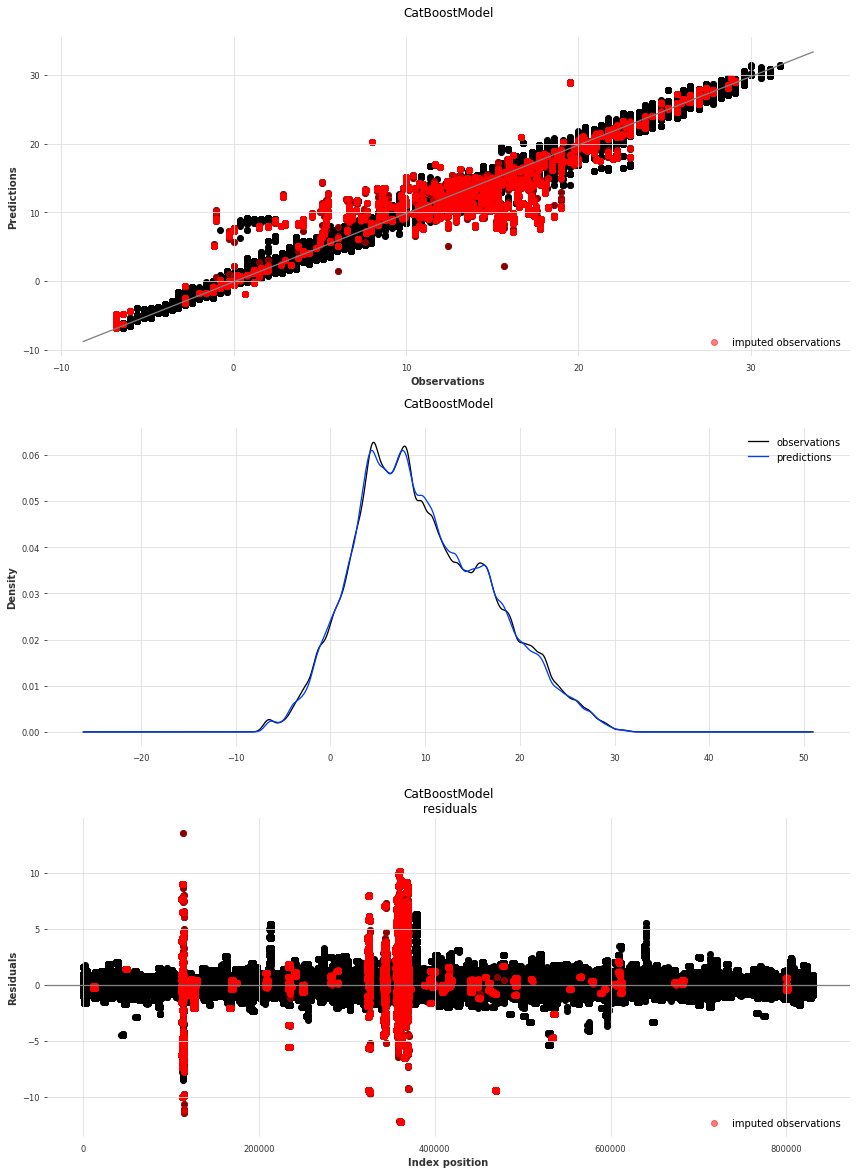

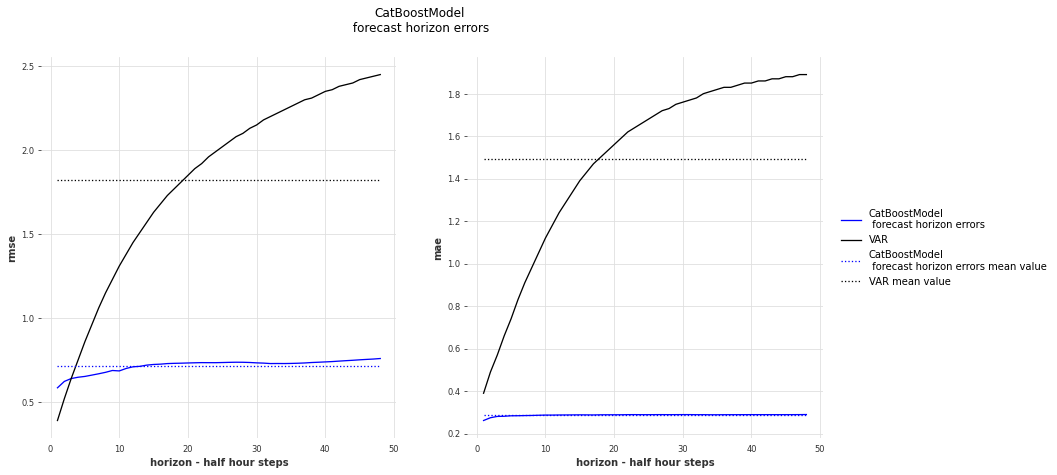

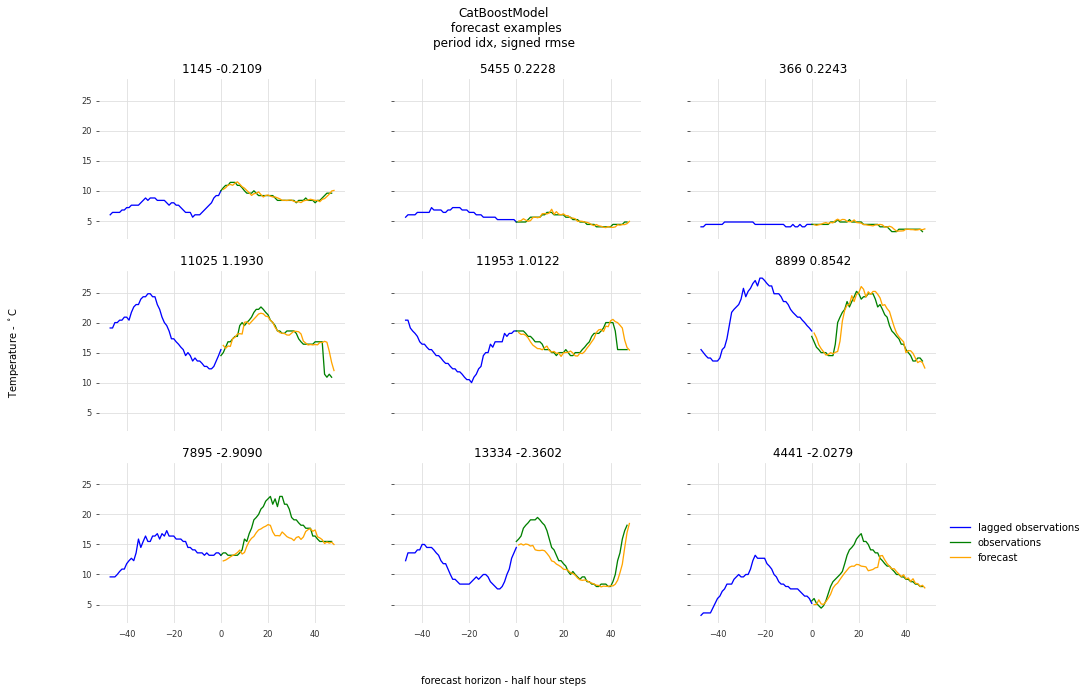

In [ ]:
# title = 'LightGBMModel\n'
title = 'CatBoostModel\n'
plot_obs_vs_preds(hist_comp, title)
plot_obs_preds_dists(hist_comp['y_des'], hist_comp['pred'], title)
plot_residuals(hist_comp, title + ' residuals')
plot_horizon_metrics(hist_comp, title + ' forecast horizon errors')
plot_forecast_examples(hist_comp, title + ' forecast examples')

In [ ]:
from scipy import stats

from darts.models import RegressionModel
#from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from darts.models.forecasting.random_forest import RandomForest
from darts.models.forecasting.catboost_model import CatBoostModel

from darts import TimeSeries
from darts.metrics import rmse, mae


series = TimeSeries.from_dataframe(train_df, value_cols='y_des')
ser_seas = TimeSeries.from_dataframe(train_df, value_cols='y_seasonal')
#ser_sta = series.stack(ser_seas)
#train = train_df['y']

# n_estimators=500
#Backtest RMSE: 2.846190354455204
#Backtest MAE: 2.212258506375625

# max_bin=512, n_estimators=500
#Backtest RMSE: 2.8349944993108234
#Backtest MAE: 2.2130271024025903

# y_des & year spline terms & dew.point_des
#Backtest RMSE: 2.7747270521469765
#Backtest MAE: 2.1646906940992183

# y_des & year spline terms
#Backtest RMSE: 2.7687921599667233
#Backtest MAE: 2.160233038384145

# y_des
#Backtest RMSE: 2.7674019527783225
#Backtest MAE:  2.155125659171155

# stack y and y_seaonal
# no fut_cov again but add the fut_cov to the past_cov, lags=24 + 47 48 49 & lags_past_covariate=6 & objective='regression_l1'
#Backtest RMSE = 1.729427454885266
#Backtest['y'] RMSE = 2.894769986641844
#Backtest['y_seasonal'] RMSE = 0.5640849231286879
#Backtest MAE = 1.3253231691671756
#Backtest['y'] MAE = 2.23253033917475
#Backtest['y_seasonal'] MAE = 0.41811599915960124

# no fut_cov again but add the fut_cov to the past_cov, lags=24 + 47 48 49 & lags_past_covariate=6 & objective='regression_l1'
#Backtest RMSE = 2.895080494562772
#Backtest MAE = 2.229618519210862

# no fut_cov again but add the fut_cov to the past_cov, lags=24 + 47 48 49 & lags_past_covariate=6 & objective='huber'
#Backtest RMSE = 3.335076358259621
#Backtest MAE = 2.590937012261161

# no fut_cov again but add the fut_cov to the past_cov, lags=24 & lags_past_covariate=3
#Backtest RMSE = 2.8659605244129427
#Backtest MAE = 2.217698950003095

# no fut_cov again but add the fut_cov to the past_cov, lags=24 & lags_past_covariate=6
#Backtest RMSE = 2.8600072764883095
#Backtest MAE = 2.2150699259900906

# no fut_cov again but add the fut_cov to the past_cov, lags=24 & lags_past_covariate=12
#Backtest RMSE = 2.862270998022728
#Backtest MAE = 2.2203471159839574

# no fut_cov again but add the fut_cov to the past_cov
# Backtest RMSE = 2.845368725980854
# Backtest MAE = 2.217012244660949

# no fut_cov
#Backtest RMSE = 2.9604175418985035
#Backtest MAE = 2.294551983733174

# lags=24 lags_past_covariate=24 lags_future_covariates=48 .. -24
# Backtest RMSE = 4.940241663244908
# Backtest MAE = 3.8395647168421325

# lags=24 lags_past_covariate=24 lags_future_covariates=0 .. -24
#Backtest RMSE = 4.6665697830384385
#Backtest MAE = 3.7085532221650537

# lags=12 lags_past_covariate=12 lags_future_covariates=0 .. -12
#Backtest RMSE = 4.770101481306556
#Backtest MAE = 3.807696536044734

# spline time terms in past_cov and fut_cov
#Backtest RMSE = 2.8640357272926074
#Backtest MAE = 2.22072679768831

# spline time terms in past_cov
#Backtest RMSE = 2.8640357272926074
#Backtest MAE = 2.22072679768831

# with y_seasonal in past_cov and fut_cov
#Backtest RMSE = 2.8753366841331136
#Backtest MAE = 2.232190077083301

# with y_seasonal in past_cov
#Backtest RMSE = 2.8636835966221823
#Backtest MAE = 2.2219438276456454

# Using ALL the training data
#Backtest RMSE = 2.8464292656568504
#Backtest MAE = 2.2037240743591733

# past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(['y', 'day.cos', 'day.sin', 'year.cos', 'year.sin'])])
#Backtest RMSE = 3.0181924465125363
#Backtest MAE = 2.349534159678457

# fut_cov_cols = ['day.cos', 'day.sin', 'year.cos', 'year.sin']
# lags_future_covariates=[0, -1, -2, -3, -23, -24, -47, -48]
# start=0.5
#Backtest RMSE = 2.9865122787499163
#Backtest MAE = 2.362791884987205

#past_cov_cols = ['dew.point', 'humidity', 'pressure', 'wind.x', 'wind.y', 'day.cos', 'day.sin', 'year.cos', 'year.sin']
#Backtest RMSE = 3.0496085167739677
#Backtest MAE = 2.3855203695482157

#lags_past_covariates=6
#Backtest RMSE = 3.106430341753366
#Backtest MAE = 2.4206074099337944

#lags_past_covariates=12
#Backtest RMSE = 3.088770657156802
#Backtest MAE = 2.418574824497032

#lags_past_covariates=24
#Backtest RMSE = 3.112853360606681
#Backtest MAE = 2.433868390325005

#lags=24
#Backtest RMSE = 3.08200547208178
#Backtest MAE = 2.4022319293660446

#lags=[-1, -2, -22, -23, -24, -25, -47, -48, -49]
#Backtest RMSE = 3.075556158887113
#Backtest MAE = 2.3982482047138687

#past_cov_cols = ['dew.point', 'humidity', 'wind.x', 'wind.y', 'day.cos', 'day.sin', 'year.cos', 'year.sin']
#Backtest RMSE = 3.08690569916074
#Backtest MAE = 2.4113522996284553

#past_cov_cols = ['dew.point', 'humidity', 'wind.x', 'wind.y', 'day.cos', 'day.sin']
#Backtest RMSE = 3.126440658510219
#Backtest MAE = 2.4374677903544284

#past_cov_cols = ['dew.point', 'humidity', 'wind.x', 'wind.y']
#Backtest RMSE = 3.1427618058526874
#Backtest MAE = 2.446286111088502

#past_cov_cols = ['dew.point', 'humidity', 'wind.x', 'wind.y', 'missing']
#Backtest RMSE = 3.161663935138472
#Backtest MAE = 2.4588186243365944

#fut_cov_cols = ['day.cos', 'day.sin', 'year.cos', 'year.sin', 'y_seasonal', \
#                'spline_0', 'spline_1', 'spline_2', 'spline_3', 'spline_4', \
#                'spline_5', 'spline_6', 'spline_7', 'spline_8', 'spline_9', \
#                'spline_10', 'spline_11']
#fut_cov = TimeSeries.from_dataframe(train_df.loc[:, fut_cov_cols])
#val_fut_cov  = TimeSeries.from_dataframe(valid_df.loc[:, fut_cov_cols])

#fut_cov_cols.append('y')
#print("fut_cov_cols:", fut_cov_cols)

#past_cov_cols = ['dew.point', 'humidity', 'pressure', 'wind.x', 'wind.y']
#past_cov = TimeSeries.from_dataframe(train_df.loc[:, past_cov_cols])
#past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns not in ['y', 'day.cos', 'day.sin', 'year.cos', 'year.sin']])
#past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(['y', 'day.cos', 'day.sin', 'year.cos', 'year.sin'])])
#past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(fut_cov_cols)])
#past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(['y'])])
past_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns.difference(['y', 'y_seasonal', 'y_des', 'dew.point_des', 'dew.point_seasonal'])])
#series_cov = TimeSeries.from_dataframe(train_df.loc[:, train_df.columns != 'y'])



threshold_date = "20171230"
train, val = series.split_before(pd.Timestamp(threshold_date))
#train, val = ser_sta.split_before(pd.Timestamp(threshold_date))
train_past_cov, val_past_cov = past_cov.split_before(pd.Timestamp(threshold_date))
#train_fut_cov, val_fut_cov = fut_cov.split_before(pd.Timestamp(threshold_date))


#from darts.dataprocessing.transformers import Scaler
#scaler_ser = Scaler()
#scaler_cov = Scaler()
#train_ser_scaled = scaler_ser.fit_transform(train)
#train_cov_scaled = scaler_cov.fit_transform(train_past_cov)
train_ser_scaled = train
train_cov_scaled = train_past_cov


#val = valid_df['y']
val_ser = TimeSeries.from_dataframe(valid_df, value_cols='y_des')
val_seas = TimeSeries.from_dataframe(valid_df, value_cols='y_seasonal')
#val_sta = val_ser.stack(val_seas)
#val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns not in ['y', 'day.cos', 'day.sin', 'year.cos', 'year.sin']])
#val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns.difference(['y', 'day.cos', 'day.sin', 'year.cos', 'year.sin'])])
#val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns.difference(fut_cov_cols)])
#val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns.difference(['y'])])
val_past_cov = TimeSeries.from_dataframe(valid_df.loc[:, valid_df.columns.difference(['y', 'y_seasonal', 'y_des', 'dew.point_des', 'dew.point_seasonal'])])



#print("val_ser:", type(val_ser))
#print("val_ser:", val_ser.shape)
#print("val_ser:", val_ser.head())

display("valid_df['y_des']:", valid_df['y_des'].describe())
#display("valid_df['y_seasonal']:", valid_df['y_seasonal'].describe())

#y_test,  _, X_test,  _ = temporal_train_test_split(valid_df['y'], valid_df.loc[:, past_cov_cols], fh=48)


#regressor = LGBMRegressor(n_estimators=50, max_depth=5, learning_rate=0.01)
#regressor = LGBMRegressor(objective='regression_l1')

#	 max_bin	n_estimators	learning_rate	num_leaves	rmse	mae
# 6	   512	500	0.010	64	2.774898	2.163858
#regressor = LGBMRegressor(max_bin=512, n_estimators=500)
#regressor = LGBMRegressor(n_estimators=500)
regressor = LGBMRegressor()
#model = RegressionModel(lags=[-1, -2, -22, -23, -24, -25, -47, -48, -49],#, -142, -143, -144, -145],#, -95, -96, -97, -143, -144, -145], # 36.54791667418908
model = RegressionModel(lags=24,#[-1, -2, -22, -23, -24, -25, -47, -48, -49],#, -142, -143, -144, -145],#, -95, -96, -97, -143, -144, -145], # 36.54791667418908
                        lags_past_covariates=3,#[-1, -2, -3],#, -47, -48, -49],
                        #lags_future_covariates=[    
                        #                        48, 47, 46, 45, 44, 43, 42, 41, 40,
                        #                        39, 38, 37, 36, 35, 34, 33, 32, 31, 30,
                        #                        29, 28, 27, 26, 25, 
                        #                        -24, -23, -22, -21, -20, \
                        #                        -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,
                        #                         -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1, \
                        #                        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, \
                        #                        13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, \
                        #                        25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, \
                        #                        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
                        output_chunk_length=48,
                        #model=KNeighborsRegressor())
                        #model=SVR())  # way too slow
                        #model=HuberRegressor())
                        model=regressor)

#model.fit(train_ser_scaled, 
#          past_covariates=train_cov_scaled)#,
#          #future_covariates=train_fut_cov)
model.fit(series, 
          past_covariates=past_cov)#,
          #future_covariates=fut_cov)
backtest = model.historical_forecasts(series=val_ser, 
                                      past_covariates=val_past_cov,
                                      #future_covariates=val_fut_cov,
                                      start=0.01, 
                                      retrain=False,
                                      verbose=True, 
                                      forecast_horizon=48,)
                                      #last_points_only=False)

if len(backtest[0]) == 1:
  print("\nBacktest RMSE:", rmse(val_ser, backtest))
  print("Backtest MAE:",     mae(val_ser, backtest))
  print("\nbacktest:", stats.describe(backtest['y_des'].values()))
  
stop()


def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns = dictionary.keys())

# From: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# Use large max_bin (may be slower)
# Use small learning_rate with large n_estimators (aka num_iterations)
# Use large num_leaves (may cause over-fitting)

# Defaults:
# max_bin       = 255
# n_estimators  = 100
# learning_rate = 0.1
# num_leaves    = 31
# max_depth     = -1 (no limit)

param_grid = {
 'max_bin':       [512, 1024],
 'n_estimators':  [200, 500],
 'learning_rate': [0.001, 0.01],
 'num_leaves':    [64, 128],
 }

#param_grid = {
# 'n_estimators':  [25, 50],
# 'max_depth':     [3, 5, 10],
# 'learning_rate': [0.001, 0.01]
# }

#param_grid = {
# 'n_estimators':  [100, 500],
# 'max_depth':     [3, 5, 10],
# 'learning_rate': [0.01, 0.1]
# }

param_df = expand_grid(param_grid)
param_df['rmse'] = 10.0
param_df['mae']  = 10.0


#for i in range(len(param_df)):
for i in param_df.index:
    m_bin, n_est, lr, nl = param_df.loc[i, ['max_bin', 'n_estimators', 'learning_rate', 'num_leaves']]
    n_est = int(n_est)
    m_bin = int(m_bin)
    nl    = int(nl)
    # print(n_est, max_d, lr)
    regressor = LGBMRegressor(max_bin=m_bin, n_estimators=n_est, learning_rate=lr, num_leaves=nl)
    ##model = RegressionModel(lags=[-1, -2, -22, -23, -24, -25, -47, -48, -49, -142, -143, -144, -145],#, -95, -96, -97, -143, -144, -145], # 36.54791667418908
    ##                        lags_past_covariates=[-1, -2, -3],#, -47, -48, -49],
    ##                        #lags_future_covariates=[-1, -2, -3, -23, -24, -25, -47, -48, -49],
    ##                        output_chunk_length=48,
    ##                        #model=KNeighborsRegressor())
    ##                        #model=SVR())  # way too slow
    ##                        #model=HuberRegressor())
    ##                        model=regressor)
    #model = RegressionModel(lags=24,#[-1, -2, -22, -23, -24, -25, -47, -48, -49],#, -142, -143, -144, -145],#, -95, -96, -97, -143, -144, -145], # 36.54791667418908
    #                        lags_past_covariates=12,#[-1, -2, -3],#, -47, -48, -49],
    #                        lags_future_covariates=[0, -1, -2, -3, -23, -24, -47, -48], 
    #                        output_chunk_length=48,
    #                        #model=KNeighborsRegressor())
    #                        #model=SVR())  # way too slow
    #                        #model=HuberRegressor())
    #                        model=regressor)   
    #model.fit(train_ser_scaled, 
    #          past_covariates=train_cov_scaled,
    #          future_covariates=train_fut_cov)
    ##pred_ser = model.predict(series=train_ser_scaled,
    ##                         past_covariates=train_cov_scaled,
    ##                         #future_covariates=train_fut_cov,
    ##                         n=48)
    ##rmse_ = rmse(val, pred_ser)
    ##mae_  = mae(val, pred_ser)
    ##rmse_, mae_ = custom_evaluate(model, cv, y_test, X_test)
    #backtest = model.historical_forecasts(series=val_ser, 
    #                                      past_covariates=val_past_cov,
    #                                      future_covariates=val_fut_cov,
    #                                      #start=0.01, 
    #                                      retrain=False,
    #                                      verbose=True, 
    #                                      forecast_horizon=48)
    model = RegressionModel(lags=24,#[-1, -2, -22, -23, -24, -25, -47, -48, -49],#, -142, -143, -144, -145],#, -95, -96, -97, -143, -144, -145], # 36.54791667418908
                            lags_past_covariates=3,#[-1, -2, -3],#, -47, -48, -49],
                            output_chunk_length=48,
                            model=regressor)
    model.fit(series, 
              past_covariates=past_cov)
    backtest = model.historical_forecasts(series=val_ser, 
                                          past_covariates=val_past_cov,
                                          start=0.01, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=48,)
                                          #last_points_only=False)
    display("backtest:", stats.describe(backtest['y_des'].values()))
    rmse_ = rmse(val_ser, backtest)
    mae_  = mae(val_ser, backtest)
    param_df.at[i, 'rmse'] = rmse_
    param_df.at[i, 'mae']  = mae_
    display(param_df.loc[i, :])
    #print()
    #display(i, rmse_, mae_)
    #stop()

    #if res < best_mape:
    #    best_mape = res
    #    best_theta = theta


display(param_df.sort_values('rmse'))
stop()


#	 max_bin	n_estimators	learning_rate	num_leaves	rmse	mae
# 6	   512	500	0.010	64	2.774898	2.163858
# 14	1024	500	0.010	64	2.780408	2.167905
# 7	   512	500	0.010	128	2.791457	2.174728
# 15	1024	500	0.010	128	2.792647	2.177302
# 2	   512	200	0.010	64	2.797354	2.184027
# 10	1024	200	0.010	64	2.799361	2.185114
# 11	1024	200	0.010	128	2.799939	2.184456
# 3	   512	200	0.010	128	2.801693	2.184923
# 13	1024	500	0.001	128	3.104122	2.420695
# 5	   512	500	0.001	128	3.104610	2.420892
# 12	1024	500	0.001	64	3.109835	2.426475
# 4	   512	500	0.001	64	3.110239	2.426476
# 9	  1024	200	0.001	128	3.332778	2.593997
# 1	   512	200	0.001	128	3.332797	2.594249
# 8	  1024	200	0.001	64	3.334497	2.595884
# 0	   512	200	0.001	64	3.334829	2.596151


model = RegressionModel(lags=[-1, -2, -22, -23, -24, -25, -47, -48, -49, -142, -143, -144, -145],#, -95, -96, -97, -143, -144, -145], # 36.54791667418908
                        lags_past_covariates=[-1, -2, -3],#, -47, -48, -49],
                        #lags_future_covariates=[-1, -2, -3, -23, -24, -25, -47, -48, -49],
                        output_chunk_length=48,
                        #model=KNeighborsRegressor())
                        #model=SVR())  # way too slow
                        #model=HuberRegressor())
                        model=LGBMRegressor())
                        #model=XGBRegressor(objective='reg:squarederror', random_state=42))


# SVR           - rmse 4.25 mae 3.89  2h 30 mins
# KNN           - rmse 4.03 mae 3.69  3 secs!
# XGBRegressor  - rmse 3.92 mae 3.56  3 mins
# LGBMRegressor - rmse 3.34 mae 3.0   1 mins
# RandomForest  - rmse 3.24 mae 2.92  2 mins
# CatBoostModel - rmse 3.0  mae 2.7   7 mins

#model = RandomForest(lags=[-1, -2, -22, -23, -24, -25, -47, -48, -49, -142, -143, -144, -145],#, -95, -96, -97, -143, -144, -145], # 36.54791667418908
#model = CatBoostModel(lags=[-1, -2, -22, -23, -24, -25, -47, -48, -49, -142, -143, -144, -145],#, -95, -96, -97, -143, -144, -145], # 36.54791667418908
#                      lags_past_covariates=[-1, -2, -3],#, -47, -48, -49],
#                      #lags_future_covariates=[-1, -2, -3, -23, -24, -25, -47, -48, -49],
#                      output_chunk_length=48,)


model.fit(train_ser_scaled, 
          past_covariates=train_cov_scaled, )
          #future_covariates=train_fut_cov)

pred_ser_scaled = model.predict(
    series=train_ser_scaled,
    past_covariates=train_cov_scaled,
    #future_covariates=train_fut_cov,
    #n=len(val)
    n=48
)

# scale back:
#pred_ser = scaler_ser.inverse_transform(pred_ser_scaled)
pred_ser = pred_ser_scaled

display("rmse:", rmse(val, pred_ser))
display("mae:",  mae(val, pred_ser))

plt.figure(figsize=(10, 6))
train[-1000:].plot(label="train")
pred_ser.plot(label="forecast")
val.plot(label="validation")



"valid_df['y_des']:"

count    17520.000000
mean        -0.357674
std          3.535530
min        -12.371429
25%         -2.567857
50%         -0.346875
75%          1.828571
max         12.914286
Name: y_des, dtype: float64

100%|██████████| 17298/17298 [06:29<00:00, 44.36it/s]


Backtest RMSE: 2.7869212271488157
Backtest MAE: 2.170964325707324


'backtest:'

DescribeResult(nobs=17298, minmax=(array([-7.54554855]), array([8.80123638])), mean=array([-0.11591467]), variance=array([5.0297731]), skewness=array([-0.20171005]), kurtosis=array([0.42372577]))

NameError: ignored

...


---


### Comparison with baselines

Finally, we can compare the best performing gradient boosted etc models against the best baseline method.  The VAR (Vector Auto-Regression) model from the [baselines notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) was the best performing baseline.

The best encoder decoder model, after 5 training epochs, was conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst.  Here I train the same model for 20 epochs.

Some points to note regarding the `plot_forecasts` diagnostic plot:
 * on validation data not test data
 * `plot_forecasts`
   * plot example forecasts with observations and lagged temperatures
      * first row shows examples of best near zero rmse forecasts
      * second row shows examples of worst positive rmse forecasts
      * third row shows examples of worst negative rmse forecasts
      * lagged observations are negative
      * the day of the year the forecast begins in and the rmse value is displayed above each sub-plot

epochs : 20
Epoch 1/5
11759/11759 [==============================] - 13s 1ms/step - loss: 30942466.0000 - mae: 142.3176


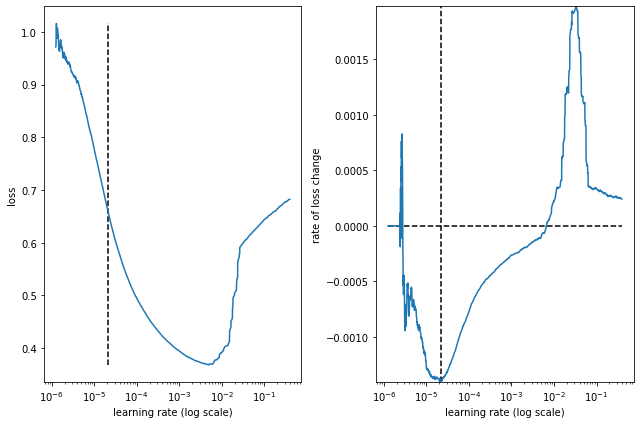

best lr: 2.1549979e-05 

Model: "conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 28, 10, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 10, 64)        512       
                                                                 
 flatten_2 (Flatten)         (None, 17920)             0         
                                                                 
 dense_6 (Dense)             (None, 448)               8028608   
                                                                 
 dense_7 (Dense)             (None, 224)               100576    
                                                                 
 dense_8 (Dense)             (None, 48)                10800     
                                                                 

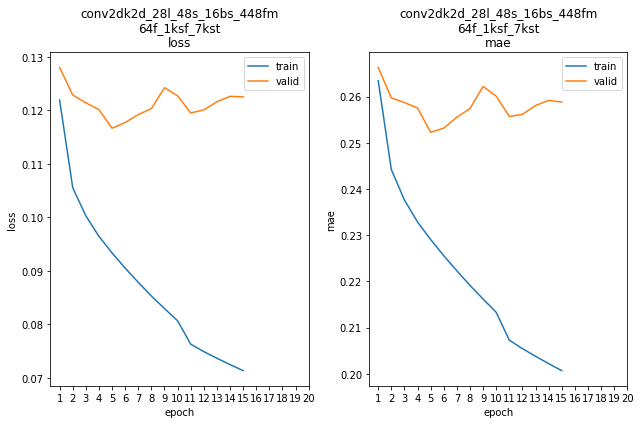

conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst train min loss: 0.071346	mae: 0.200707	epoch: 15
conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst valid min loss: 0.116655	mae: 0.252278	epoch: 5



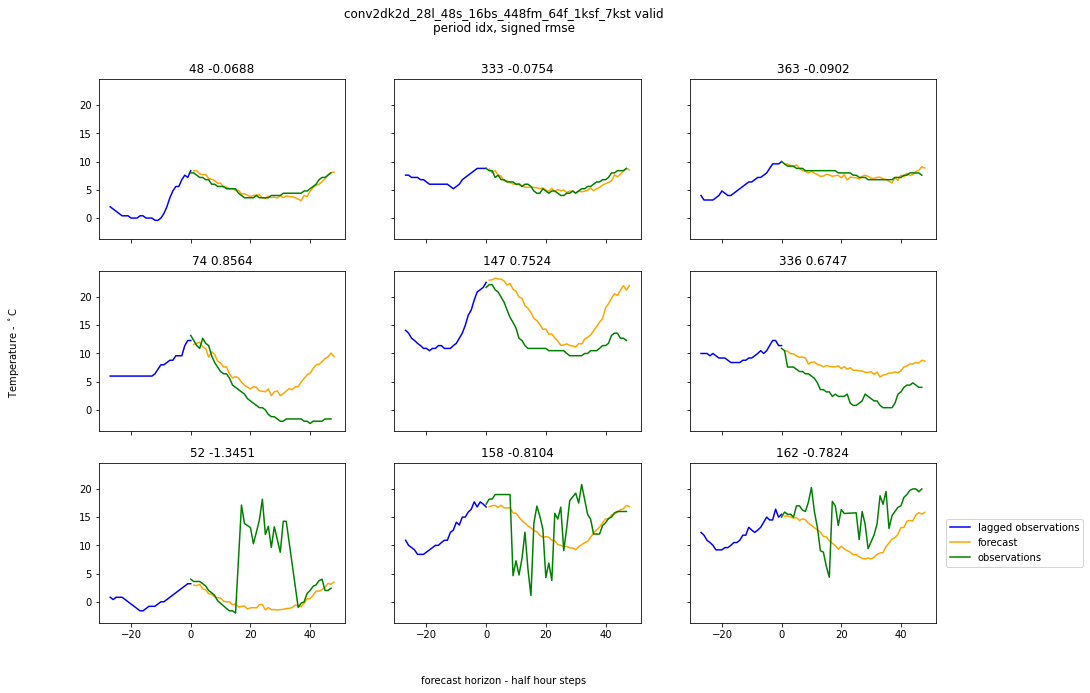

CPU times: user 20min 42s, sys: 3min 50s, total: 24min 32s
Wall time: 20min


In [ ]:
%%time


params = get_default_params('conv2dk2d')
params.update({'feat_maps':  448,
               'filters':     64,
               'lags':        28,
               'ks_feats':     1,
               'ks_time':      7,
               'lrf_params': [0.000001, 10, 32, 5, 100, 25]})
sweep_values = {'epochs': [20]}
models, epochs_model_names = sweep_param(models, params, sweep_values, verbose=True)

model_name = epochs_model_names[0]
plot_forecasts(models, model_name)

Results of the conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst model for 48 steps-ahead forecast after 20 epochs:

| CNN model             | params                         | mse     | mae     |
|-----------------------|--------------------------------|---------|---------|
|Conv2D Kern2D epochs= 5| lags=28, ks_feats=1, ks_time=7 | 0.11686 | 0.25261 |
|Conv2D Kern2D epochs=20| lags=28, ks_feats=1, ks_time=7 | 0.11665 | 0.25228 |

The model stopped training early after 15 epochs.  There was a marginal improvement in mse and mae.  As before, the minimal mse value was acheived at the 4th epoch.  The training plot shows some over-fitting.  Arguably, I should try the next best model but I doubt this will improve results by much.

Diagnostic plot summary:
 * once again, on validation data not test data
 * `plot_forecasts`
   * third row shows three highly suspect looking sets of observations for worst negative rmse forecast examples
   * clearly some remaining problem in the observations

---


Next, I plot the best Conv2D kernel 2D and VAR model rmse and mae values for forecast horizons up to 48 (24 hours, each horizon step is equivalent to 30 minutes).  This plot plus the two others are for forecasts on the previously unused 2019 "test" data.  This is different from the 2018 "validation" data used elsewhere in this notebook.

Some points to note regarding diagnostic plots:
 * once again, on test data not validation data
 * `plot_horizon_metrics`
   * plot rmse and mae values for each individual step-ahead
 * `check_residuals`
   * observations against predictions
   * residuals over time
   * residual distribution
 * `plot_forecasts`
   * see sub-section immediately above for notable points

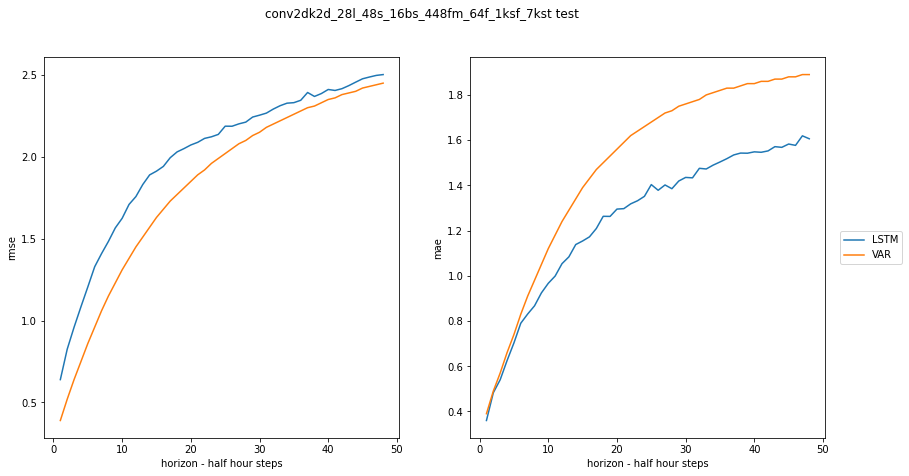

t rmse conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst: 2.057958616855633
t mae conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst:  1.179860027368246


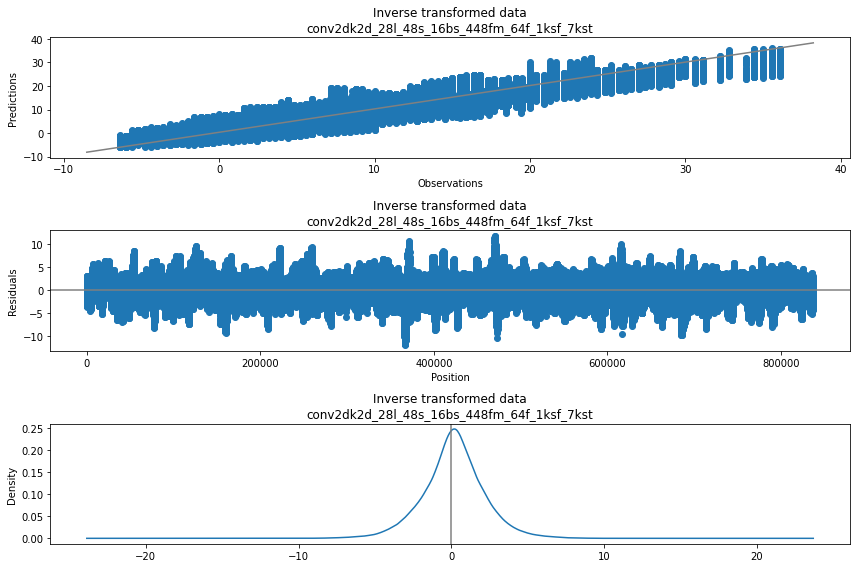

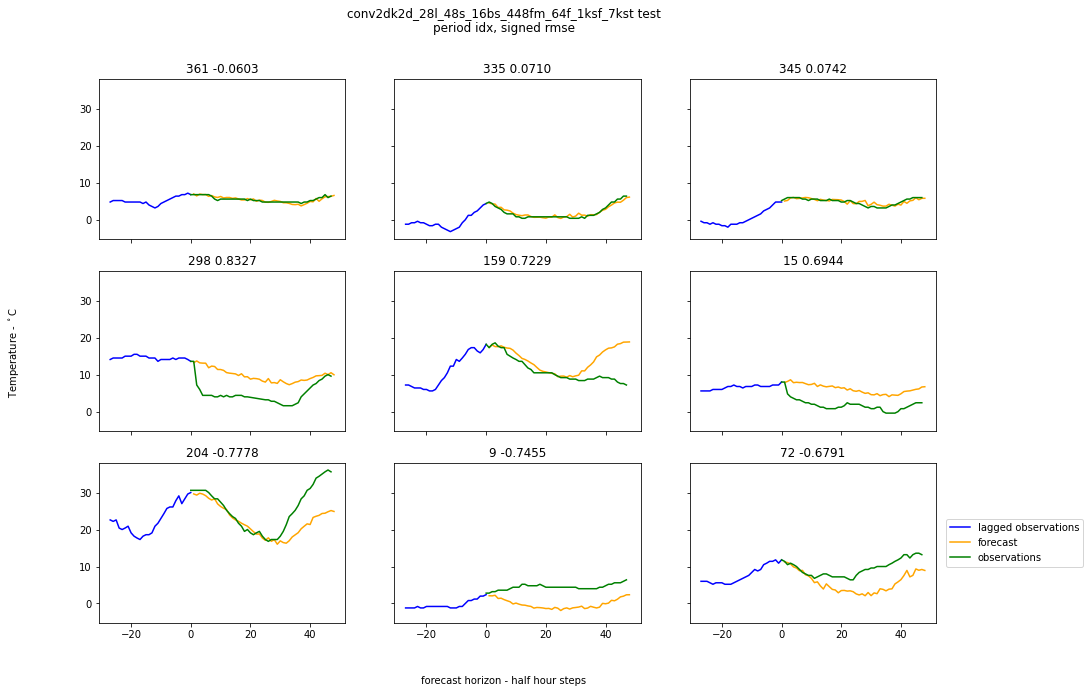

In [ ]:
ds = 'test'
best_mod = 'conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst'

plot_horizon_metrics(models, best_mod, dataset = ds)
check_residuals(models, best_mod, dataset = ds)
plot_forecasts(models, best_mod, dataset = ds)

Broadly speaking, these results are very similar to the results from the [best LSTM model](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb).


Diagnostic plots summary:
 * once again, these plots use test data not validation data
 * `plot_horizon_metrics`
   * initially, these results look quite contradictory
   * the rmse plot indicates better forecasts for the VAR method (in orange)
   * the mae plot indicates better forecasts for the Conv2D kernel 2D method (in blue, mis-labelled as LSTM)
 * `check_residuals`
   * the observations against predictions plot indicates
     * predictions are too high at cold temperatures (below 0 C) 
     * predictions are too low at hot temperatures (above 25 C)
   * residuals over time
     * no obvious heteroscadicity
     * no obvious periodicity
       * surprising given observations against predictions plot
   * residual distribution appears to be approximately normal (slightly right-skewed)
     * no obvious sign of fat tails
 * `plot_forecasts`
   * notable lack of noisy observations for the large positive and negative rmse examples

The median absolute error (mae) is less sensitive to outliers compared to the root mean squared error (rmse) metric.

Therefore, the rmse and mae plot difference may be due to the presence of outliers. I have maintained from the start that this data set is quite noisy, and attempts to correct these problems may have unintensionally introduced new issues.

Transformed mean values across the 48 step horizon:
 * rmse of 2.05796
 * mae of 1.17986

---


## Conclusion

The best results from the Conv2D kernel 2D are very similar to the results from the [best LSTM model](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb).

The conclusion is separated into the following sections:
 * What worked
 * What didn't work
 * Future work

What worked:
 * Conv1D followed by
   * LSTM layer
     * simple and reasonably effective set of models
   * 2 Dense layers
     * simple and reasonably effective set of models
 * Multi-head
   * 3 independent Conv1D "heads" with different kernel sizes
     * did not improve on single head Conv1D models
 * Conv2D
   * very high number of parameters
   * single Conv2D layer
     * feature extraction kernel
       * probably the best performing set of models
   * 2 stacked Conv2D layers
     * first feature extraction kernel
     * second temporal extraction kernel
     * reasonable results but didn't improve on single Conv2D layer
 * Inception-style
   * 6 inception modules with residual connections at the 3rd and 6th modules
     * only partially optimised but gave acceptible results
     * may benefit from larger kernel sizes - 2, 8, 16 instead of 2, 4, 8
     * slow to train
 * skopt Bayesian hyperparameter optimisation
   * summary from Conv2D models
     * lags - lower is better
       * some models showed periodicity
       * with secondary minima around 48 and 96 steps
     * feature maps - higher is better
     * filters - higher is better
     * kernel size
       * feature extraction - lower is better
       * temporal extraction - higher is better
   * more optimisation iterations are probably justifiable
   * exact order to optimise parameters in remains unclear
     * feature selection
     * lags?
     * architecture selection
     * learning rate
     * batch size
     * lags?
     * the rest!
     * regularisation parameters _later_ on (best performing models only)

What didn't work:
 * Conv2D
   * single Conv2D layer
     * combined feature-temporal extraction kernel
       * the training plot shows some over-fitting
       * it is recommended to extend training epochs from 5 to 10 to avoid this
 * Dealing with outliers remains problematic
   * further data cleaning would be beneficial
     * particularly labeling the interpolation, imputation etc missing data cases
 * Learning rate finder has issues
   * tuning the start learning rate parameter defeats the purpose of the method
     * this tuning could be replaced with multiple learning rate finder runs
     * using start learning rate parameter increasing in order of magnitude: 1e-5, 1e-4, etc
       * this was performed manually on a per-architecture basis but would benefit from automation
     * choose start learning rate that minimises loss value
     * straight-forward change but will increase running time
 * Mixup
   * the minimal mse value was higher than the Conv2D kernel 2D value without any mixup 
   * perhaps this lack of improvement may be due to the particular Conv2D kernel 2D model overfitting

Future work:
 * Further optimise model and data parameters
   * check robust regression loss functions
     * [Huber loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber)
     * less sensitive to outliers than the squared error loss
   * lags
     * 1-24 plus zero or more of {48, 96, 144, 192, 240, 288, 336}
   * seasonal components
     * one-hot encoded month variables
     * the [Short Time Fourier Transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) may be a good option for modeling the daily seasonality
       * it is available in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html)
   * batch mixup
     * probably only time series mixup
   * apply regularisation to best performing model
     * dropout, L2, time series mixup
 * Additional architectures to examine
   * Architectures for integer based variables
       * Temperatures recorded to 0.1 degrees C
       * Recorded as integers (temperature * 10)
       * Other variables?
     * Embeddings
       * ...
     * NLP focused architectures and enhancements
       * Dense output with softmax and use Beam search
       * ...
 * mse and mae horizon plots
   * add confidence intervals

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

IPython version:
5.5.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
seaborn,0.11.2
scikit-learn,1.0.2
pandas,1.3.5
numpy,1.21.6
matplotlib,3.2.2
keras,2.10.0


In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.178
BogoMIPS:            4000.35
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_si

In [ ]:
!date

Sat Jun 18 14:10:54 UTC 2022


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "gradient_boosting.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}